# Project 101
### PARTE 2 - Modelado

### Contenido
- [Introducción](#intro)
- [Data preparation](#dataprep)
- [Descomposicion de la serie](#desc)
- [Modelado](#modelos)

    - [**1. Modelos Estadísticos Clásicos**](#1)
        - [Dicky Fuller Test](#1.1)
        - [Autocorrelacion y Autocorrelacion Parcial](#1.2)
        - [SARIMAX model](#1.3)
        
    - [**2. Modelos ML**](#2) 
        - [Random Forest](#1.2)
        - [MA model](#1.3)

    - [**3. Modelos Redes Neuronales**](#2) 
        - [Neural Prophet (Facebook)](#1.3)



        - 

    - [Resultados](#resultados)


De acuerdo con los resultados obtenidos en el EDA y la validación realizada con el equipo de ventas, importacion y exportacion, concluimos en los principales motivos que deben ser modelados. Como las condiciones economicas y politicas son tan cambiantes con el fin de adaptarse a las nuevas necesidades de los clientes, Raiconet con frecuencia lanza o relanza nuevos motivos realizando cambios en las rutas, agentes y proveedores. Por ello, en el plazo del analisis de los ultimos 5 años, muchos de los motivos ya no son utilizados. 

Los prinicipales motivos a predecir son: 

__Impo:__
-   528 USA FLAT
-   544 UPS MERCOSUR
-   571 Geobox Flat
-   597 EUROPA UPS
-   550 ORIENTE UPS
-   600 Courier Oriente Flat Wish
-   598 China Latin
 
__Expo:__
 - Exporta Simple (P.A.)
 - CARGA AEREA EXPO PREPAID
 - CARGA AEREA EXPO - Q (Servicios expo Quick)
 - 4-Expo - Fedex Economy	
 - 6-Expo-UPS Express

#### Bibliografia

https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711

Clave: 
https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf

https://bookdown.org/JakeEsprabens/431-Time-Series/modelling-time-series.html

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

posibles metricas a usar 
https://medium.com/@dave.cote.msc/rdr-score-metric-for-evaluating-time-series-forecasting-models-1c23f92f80e7#:~:text=Currently%2C%20the%20most%20popular%20metrics,are%20MAE%2C%20RMSE%20and%20AIC.&text=To%20briefly%20summarize%2C%20both%20MAE,impact%20of%20the%20large%20errors.

https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27

https://towardsdatascience.com/forecasting-with-machine-learning-models-95a6b6579090

https://pypi.org/project/mlforecast/

## Description

- modelos autoregresivos clasicos→ arima
- modelos basados en arboles
- regresion lineal
- exponential smooth
- red neuronal

⇒ en los clásicos se puede agregar informacion temporal, como numero de la semana del ano, numero de la semana del mes

→ variables exógenas agregarlas despues

→ transformaciones seno y coseno al año ⇒ para patrones estacionales

—> poner el numero de la semana del mes→ cuantos días tiene el mes→ primer dia del mes de esa semana

→ feriados → hollidays libreria → feriados poner pais

→ como es la serie de tiempo en el mes → uno encima del otro normalizado hay una tendencia, hacer la prediccion mensual y despues llevarla a la semanal —>lineal, modelo que te distrbuya en la semana

ACF ⇒ autocorrelograma 

⇒ lags, seasonality,

ACP ⇒ autocorrelograma parcial

⇒ autocorrelacion

ML Flow

⇒ transformada de Furier, descomposicion de frecuencias⇒ la serie original los datos, te da una composicion por esa serie, peaks donde hay valores que se repiten

⇒ aplicar para todos⇒ escribir esta tiene este valor y esta otra no

→ Darts, Nixla, (tres librerias, statmodel, tecnicas estaddisticas clasicas, ML (aroles y lineales), modelos de deeplearning

→ Darts tiene un mix de modelos adentro

Backtesting permite hacer random testing, elegis el numero de semanas que queres predecir, depende del largo de la serie, 25 para tets, testeo solo para 5. 

Backtesting 80%

LugonTS: amazon, modelo clasico se llama DeepAR (red recurrente, mucho mas maduro), buen baseline para AR en los modelos de deep learing

__Importamos las librerias a usar__

In [1]:
import pandas as pd
import plotly_express as px
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import seaborn as sns  
from statsmodels.graphics.tsaplots import  plot_acf, plot_pacf

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg 
from statsmodels.tsa.arima_model import ARIMA, ARMA

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from sklearn import preprocessing

import time
time.clock = time.time

from sklearn.metrics import mean_squared_error, mean_absolute_error

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

__Funciones útiles__

In [2]:
def crear_dataset(df, motivo): 
    df= df[['Guias_Fecha', 'Motivo', 'Guias_Peso']]
    df['Guias_Fecha']= pd.to_datetime(df['Guias_Fecha'])
    df= df[df['Motivo']==motivo]
    df.rename(columns = {'Guias_Peso': 'y'}, inplace = True)
    df.drop(columns='Motivo', inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns= 'index', inplace= True)
    #agrupamos por semana => porque las entradas estan separadas, asi q nos quedamos con el total de kilos por fecha
    df= df.groupby(pd.Grouper(key='Guias_Fecha', axis=0, freq='W')).sum()
    df['ds']= df.index
    df = df.reset_index(drop=True)
    df= df[['ds', 'y']]
    return df

### Data Preparation <a id='dataprep'></a>

Vamos a agrupar las entradas por fecha para tener el volumen total de kilos por semana. Luego vamos a crear un df para cada motivo y entrenar los modelos.

__Importamos los datos a usar__

In [3]:
df_guias_impo= pd.read_csv('Data/Guias Impo.csv')
df_guias_expo= pd.read_csv('Data/Guias Expo.csv')

Top 7 servicios de IMPO

In [4]:
df_impo_1= crear_dataset(df_guias_impo,'USA FLAT')
df_impo_1.to_csv('Data/Modelado/impo 1 - USA FLAT.csv', index=False)

df_impo_2= crear_dataset(df_guias_impo, 'ORIENTE UPS')
df_impo_2.to_csv('Data/Modelado/impo 2 - ORIENTE UPS.csv', index=False)

df_impo_3= crear_dataset(df_guias_impo, 'CHINA LATIN LOGISTIC  CO via UPS/FEDEX')
df_impo_3.to_csv('Data/Modelado/impo 3 - CHINA LATIN LOGISTIC.csv', index=False)

df_impo_4= crear_dataset(df_guias_impo, 'EUROPA UPS')
df_impo_4.to_csv('Data/Modelado/impo 4 - EUROPA UPS.csv', index=False)

df_impo_5= crear_dataset(df_guias_impo, 'Courier Oriente FLAT Wish/Latin logistic')
df_impo_5.to_csv('Data/Modelado/impo 5 - Courier Oriente FLAT Wish.csv', index=False)

df_impo_6= crear_dataset(df_guias_impo, 'Impo Geobox Flat ')
df_impo_6.to_csv('Data/Modelado/impo 6 - Impo Geobox Flat.csv', index=False)

df_impo_7= crear_dataset(df_guias_impo, 'UPS MERCOSUR')
df_impo_7.to_csv('Data/Modelado/impo 7 - UPS MERCOSUR.csv', index=False)

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3613063879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Guias_Fecha']= pd.to_datetime(df['Guias_Fecha'])


Top 5 servicios de EXPO

In [5]:
df_expo_1= crear_dataset(df_guias_expo, 'Exporta Simple - Puerta-Aeropuerto')
df_expo_1.to_csv('Data/Modelado/expo 1 - Exporta Simple - Puerta-Aeropuerto.csv', index=False)

df_expo_2= crear_dataset(df_guias_expo, 'CARGA AEREA EXPO PREPAID')
df_expo_2.to_csv('Data/Modelado/expo 2 - CARGA AEREA EXPO PREPAID.csv', index=False)

df_expo_3= crear_dataset(df_guias_expo, 'CARGA AEREA EXPO - Q')
df_expo_3.to_csv('Data/Modelado/expo 3 - CARGA AEREA EXPO - Q.csv', index=False)

df_expo_4= crear_dataset(df_guias_expo, '4-Expo - Fedex Economy')
df_expo_4.to_csv('Data/Modelado/expo 4 - 4-Expo - Fedex Economy.csv', index=False)

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3613063879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Guias_Fecha']= pd.to_datetime(df['Guias_Fecha'])


De esta forma, obtenemos por cada motivo un dataframe con dos columnas: 'ds' la fecha que permite identificar la semana y 'y' el total de kilos transportados para esa semana. Tambien, crearemos un diccionario para poder identificar mas adelante a que sigla corresponde cada motivo, por cuestiones practicas fueron resumidos en el tipo de servicio y un numero.

In [6]:
df_impo_1.head()

ds       y
0 2019-01-06  1950.0
1 2019-01-13  2402.0
2 2019-01-20  2782.0
3 2019-01-27  3263.0
4 2019-02-03  3843.0

Contrui un diccionario que permite mapear el nombre del dataframe designado con el nombre del motivo, para permitir un analisis mas prolijo y no perder referencia sobre el motivo sobre el que estare trabajando

In [7]:
lista_df= ['df_impo_1', 'df_impo_2', 'df_impo_3', 'df_impo_4', 'df_impo_5','df_impo_6', 'df_impo_7',
           'df_expo_1', 'df_expo_2', 'df_expo_3', 'df_expo_4']
nombres_motivos= ['528 USA FLAT', '550 ORIENTE UPS','598 CHINA LATIN LOGISTIC', '597 EUROPA UPS', '600 Flat Wish', '571 Geobox Flat', 'UPS MERCOSUR', 
            'Exporta Simple', 'CARGA AEREA EXPO PREPAID', 'CARGA AEREA EXPO - Q', '4-Expo - Fedex Economy']
dic_num_motivos= {lista_df[i]: nombres_motivos[i] for i in range(len(lista_df))}

### Descomposición de la serie <a id='desc'></a>

Para esta sección previo a comenzar a modelar estudiaré la composición de las series de tiempo para cada motivo, de que forma se autocorrelacionan, si existen patrones intrínsicos o factores externos que pueden influir en el posterior entrenamineto del modelo. 

##### Distribución Semanal por Motivo

Observando las distribuciones para cada motivo seleccionado, observamos como poseen cualidades y patrones muy diferentes entre si. Ademas algunos motivos son recientes por lo que no hay datos previos al 2022 como en el caso de Geobox Flat, o incluso hay otros motivos como por ejemplo 598 y 600 ambos de la sede de China que presentan semanas en donde el volumen es cero, estos estancamientos se deben en gran medida en que son motivos complementarios y deberian presentar patrones y comportamientos similares. 

Cada motivo posee su particularidad y esta expuesto a distintos eventos externos como pueden ser medidas que afecten directamente al servicio como medidas aduaneras para la exportacion o para la importacion, o incluso como representan rutas especificas sus variaciones pueden responder a la demanda de los clientes por estas rutas o las interrupciones que pueden haber en las mismas. 

Cada una de las series presentadas representan diversos factores que influyen en su comportamiento, para ello en esta seccion intentare descomponer y comprender que factores realmente inciden y si estos son comun para los motivos seleccionados. 

In [8]:
lista_dataframe= [df_impo_1, df_impo_2, df_impo_3, df_impo_4, df_impo_5,df_impo_6, df_impo_7,
           df_expo_1, df_expo_2, df_expo_3, df_expo_4]

n= 0

for df in lista_dataframe: 
    
    a= lista_df[n]
    b= dic_num_motivos[a]
    
    fig = px.line(df, x='ds', y='y', title=f"Volumen de Kilos Semanal {a[3:]} <br><sup>{b}</sup>")

    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
        )
    
    n+=1
    
    fig.show()


### Modelado


Antes de comenzar a evaluar y analizar posibles modelos, determinare las metricas a utilizar y las con las cuales compararemos mas adelante las performance de cada modelo.

Las metricas de evaluacion elegidas para el forecasting son: 

Scale Dependent Metrics: 
- MAE (Mean Absolute Error): Permite una facil interpretacion ya que mide el error promedio en terminos absolutos, es decir nos permite comparar que tan bueno es el modelo en terminos de errores promedio en unidades absolutas de kilos. Ademas, a diferencia del RMSE no penaliza los outliers. 

- RMSE (Root Mean square error): mide los errores y penaliza a los errores que sean grandes, es el promedio de la diferencia cuadratica entre los valores reales y los valores predichos
    
- sMAPE: es una medida facil de interpretar ya que permite identificar en terminos de porcentaje que tan bueno es el modelo en predecir y que porcentaje de error posee. Aunque la media sea susceptible al efecto de valores atipicos aun asi es una buena metrica para comparar distintos tipos de modelos con el mismo set de datos. Ademas a diferencia del MAPE no es sensible a valores cercanos a cero, y como para las series existen valores cercanos a cero es preferible utilizar esta metrica. 

In [9]:
# creamos una tabla donde guardar los resultados de los modelos que corremos 
comparison_tbl = pd.DataFrame(columns = ['Serie',
                                        'Modelo',
                                        'MAE',
                                        'RMSE', 
                                        'sMAPE',
                                        'Processing Time'])

i_index=[]
i_index = -1

models = []

Definimos las funciones de las metricas a utilizar 

In [10]:
def calculate_smape(actual_values, forecasted_values):
    absolute_percentage_errors = []
    
    for actual, forecasted in zip(actual_values, forecasted_values):
        numerator = abs(actual - forecasted)
        denominator = (abs(actual) + abs(forecasted)) + 1e-9  # Agregar una constante para evitar división por cero
        ape = numerator / (denominator / 2)
        absolute_percentage_errors.append(ape)
    
    smape = sum(absolute_percentage_errors) / len(absolute_percentage_errors)
    return smape


#### 1. Modelos Estadísticos Clásicos

En esta seccion analizaré y compararé modelos estadísticos clasicos: AR, MA, ARMA y Arima. Por ello antes de comenzar a modelar aplicaremos los test correspondientes de autocorrelacion y autocorrelacion parcial para conocer las caracteristicas de las series y luego poder decidir que modelos estadisticos podrian ser aplicados. 
Como la autocorrelación supone que las series son estacionarias antes de comenzar a analizarlas debemos verificar que lo sean, para ello utilice el ADF (Augmented Dicky-Fuller Test), una vez obtenidas las series estacionarias aplicare los test ACF y PACF, luego para las series no estacionarias las transformare para convertirlas en estacionaria y poder aplicar los test. 

Mas adelante, una vez analizados los resultados, aplicare los modelos de acuerdo a los resultados obtenidos para cada serie. 

Por otro lado, aparte de encontrar patrones en las series los resultados de los test de autocorrelacion no solo aportaran para aplicar los modelos clasicos sino que tambien poseen un impacto practico en modelos de ML y Deep Learning ya que nos permiten tomar decisiones a la hora de modelar y tunear hiperparametros


##### ACF & PACF 

Como la autocorrelacion supone que las series son estacionarias antes de comenzar a analizarlas debemos verificar que lo sean, para ello utilice el ADF (Augmented Dicky-Fuller Test) 

Autocorrelograma

Apart of finding patterns and allowing know your data better ACF has also significant practical impact in predictive data analysis. For instance if you are using deep learning for data prediction you can build more efficient and simpler models (therefore less computation demanding) by ignoring values (creating smaller learning batches) that statistically do not have impact on data.


Autocorrelation analysis is an important step in the Exploratory Data Analysis (EDA) of time series. The autocorrelation analysis helps in detecting hidden patterns and seasonality and in checking for randomness. It is especially important when you intend to use an ARIMA model for forecasting because the autocorrelation analysis helps to identify the AR and MA parameters for the ARIMA model.

#### ADF - Augmented Dicky-Fuller 

##### Test de Estacionalidad

ACF and PACF assume stationarity of the underlying time series. Staionarity can be checked by performing an Augmented Dickey-Fuller (ADF) test:

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
[...] We can see that our [ADF] statistic value [...] is less than the value [...] at 1%. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. - Machine Learning Mastery: How to Check if Time Series Data is Stationary with Python

If the time series is stationary, continue to the next steps. If the time series is not stationary, try differencing the time series and check its stationarity again.

In [11]:
def check_stationarity(series):
    # Copiado de https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [12]:
n=0
for df in lista_dataframe:
    a= lista_df[n]
    b= dic_num_motivos[a]
    print('.......................................', '\n',f'{a}', '\n', f'{b}', '\n')
    check_stationarity(df['y'])
    n+=1

....................................... 
 df_impo_1 
 528 USA FLAT 

ADF Statistic: -4.304913
p-value: 0.000436
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574
Stationary
....................................... 
 df_impo_2 
 550 ORIENTE UPS 

ADF Statistic: -2.015910
p-value: 0.279641
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Non-stationary
....................................... 
 df_impo_3 
 598 CHINA LATIN LOGISTIC 

ADF Statistic: -4.931840
p-value: 0.000030
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Stationary
....................................... 
 df_impo_4 
 597 EUROPA UPS 

ADF Statistic: -1.847862
p-value: 0.356971
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Non-stationary
....................................... 
 df_impo_5 
 600 Flat Wish 

ADF Statistic: -2.697520
p-value: 0.074468
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Non-stationary
....................................... 
 df_impo_6 
 571 Geobox Flat 

ADF Statistic

Los resultados obtenidos nos indican que con un nivel de confianza al 95% podemos rechazar o no rechazar la hipotesis nula de que la serie es estacionaria. Por ello los resultados obtenidos resaltaran en verde a las que no se puede rechazar la hipotesis nula (son estacionarias) y en rojo a las que no son estacionarias por lo que se rechaza la hipotesis nula.

De esta forma obtenemos que las series que son estacionarias son: 
    
    - Impo 1
    - Impo 3
    - Impo 7
    - Expo 2
    - Expo 4

Por eso a estos motivos cuyas series son estacionarias podremos realizar el analisis de Autocorrelacion (ACF) y Autocorrelacion Parcial (PACF) 



### If the time series is stationary, continue to the next steps. If the time series is not stationary, try differencing the time series and check its stationarity again

In [13]:
series_estacionarias= [df_impo_1, df_impo_3, df_impo_7, df_expo_2, df_expo_4]
series_no_estacionarias= [df_impo_2, df_impo_4, df_impo_5, df_impo_6, df_expo_1, df_expo_3]

Autocorrelation Function (ACF)¶


Correlation between time series with a lagged version of itself. The correlation between the observation at the current time spot and the observations at previous time spots.The autocorrelation function starts a lag 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

We will be using the plot_acf function from the statsmodels.graphics.tsaplots library. (See statsmodels.tsa.stattools.acf)

The ACF plot can provide answers to the following questions:

- Is the observed time series white noise / random?

- Is an observation related to an adjacent observation, an observation twice-removed, and so on?

- Can the observed time series be modeled with an MA model? If yes, what is the order?

Partial Autocorrelation Function (PACF)¶

Additional correlation explained by each successive lagged term. The correlation between pbservations at two time spots given that we consider both observations are correlated to observations at other time spots.

The partial autocorrelation at lag k is the autocorrelation between  Xt
  and  Xt−k
  that is not accounted for by lags 1 through  k−1
 .

We will be using the plot_pacf function from the statsmodels.graphics.tsaplots library with the parameter method = "ols" (regression of time series on lags of it and on constant). (See statsmodels.tsa.stattools.pacf)

Sidenote: The default parameter for method is yw (Yule-Walker with sample-size adjustment in denominator for acovf). However, this default value is causing some implausible autocorrelations higher than 1 on the sample data. Therefore, we change the method parameter to one that is not causing this issue. ywmle would also work fine as suggested in this StackExchange post

The PACF plot can provide answers to the following questions:

- Can the observed time series be modeled with an AR model? If yes, what is the order?

Both the ACF and PACF start with a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

The difference between ACF and PACF is the inclusion or exclusion of indirect correlations in the calculation.

Furthermore, you will see a blue area in the ACF and PACF plots, which depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

#### Series Estacionarias

**Autocorrelacion (ACF) y Autocorrelacion Parcial (PACF)**

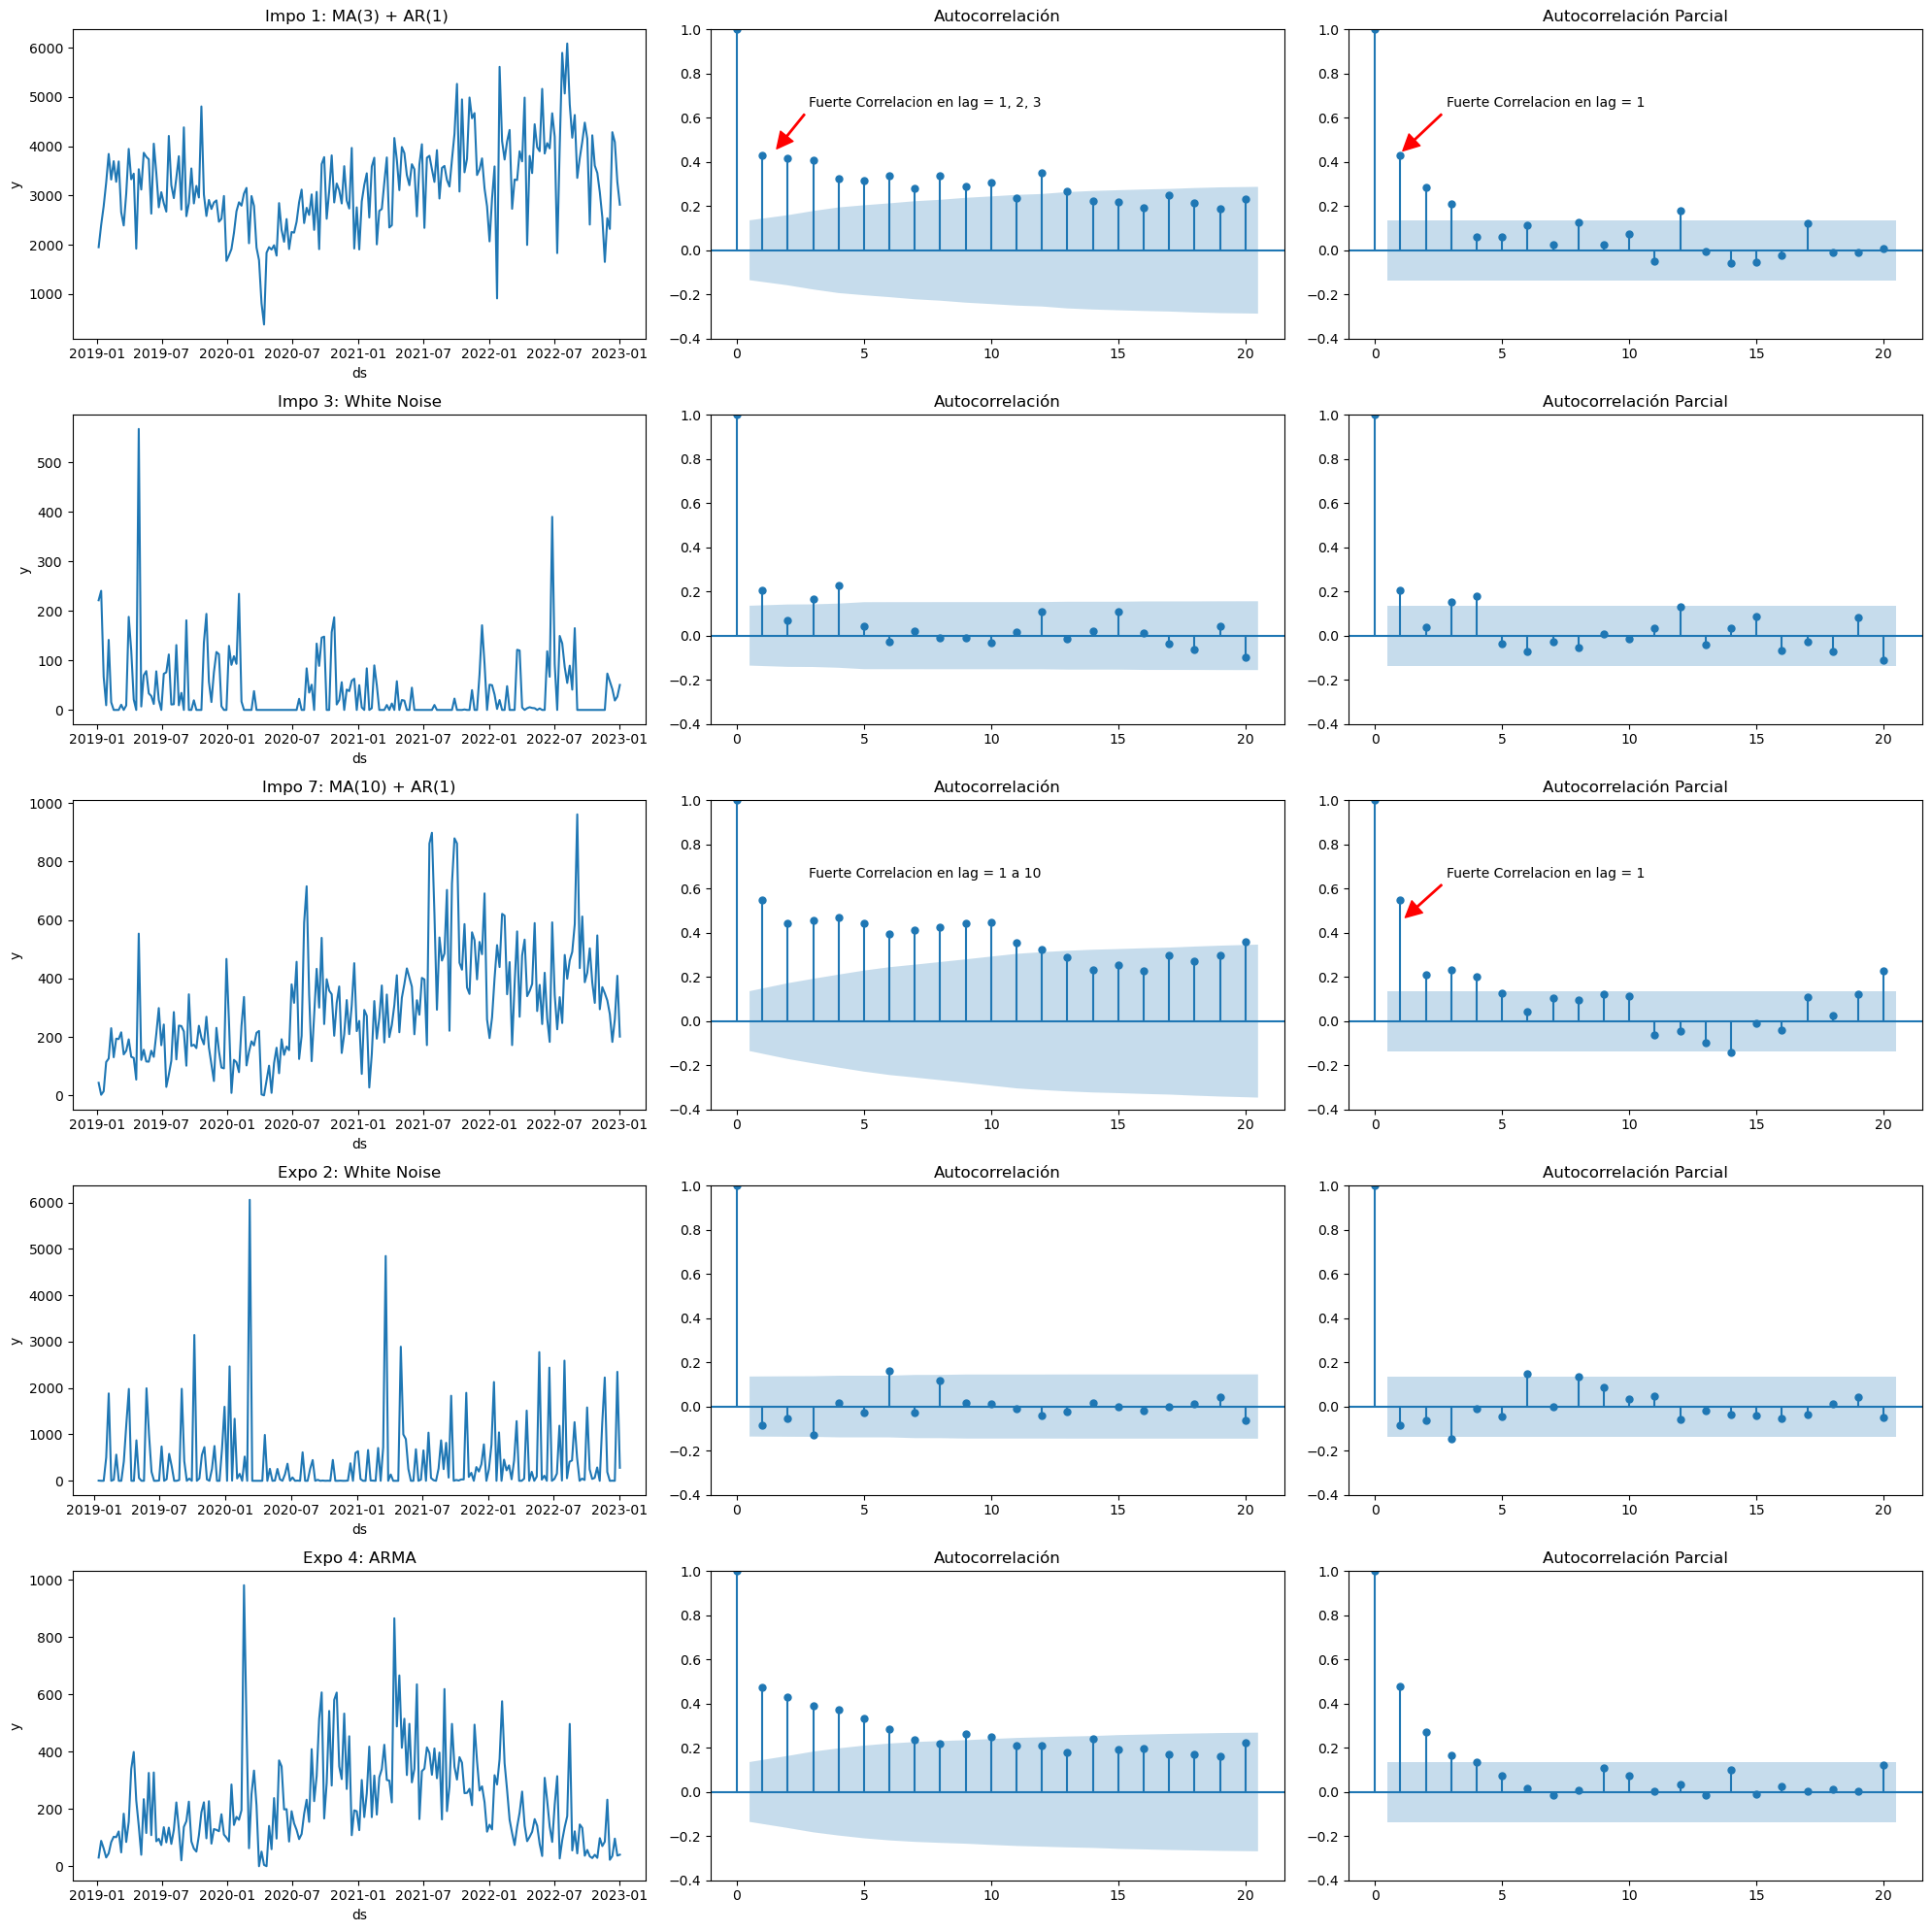

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

width = 20
height = 10
lag_acf = 20
lag_pacf = 20

# Crear la figura
f, ax = plt.subplots(nrows=5, ncols=3, figsize=(width, 2 * height))

##### Impo 1

# Graficar la serie de tiempo
sns.lineplot(x=df_impo_1['ds'], y=df_impo_1['y'], ax=ax[0, 0])
ax[0, 0].set_title('Impo 1: MA(3) + AR(1) ')

# Graficar ACF
plot_acf(df_impo_1['y'], lags=lag_acf, ax=ax[0, 1])
ax[0, 1].set_ylim(-0.4, 1)
ax[0, 1].set_title('Autocorrelación')
ax[0, 1].annotate('Fuerte Correlacion en lag = 1, 2, 3', xy=(1.5, 0.45), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))

# Graficar PACF 
plot_pacf(df_impo_1['y'], lags=lag_pacf, ax=ax[0, 2], method='ols')
ax[0, 2].set_ylim(-0.4, 1)
ax[0, 2].set_title('Autocorrelación Parcial')
ax[0, 2].annotate('Fuerte Correlacion en lag = 1', xy=(1, 0.44), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))

##### Impo 3

# Graficar la serie de tiempo para Impo 3
sns.lineplot(x=df_impo_3['ds'], y=df_impo_3['y'], ax=ax[1, 0])
ax[1, 0].set_title('Impo 3: White Noise')  # Ajusta el título según corresponda

# Graficar ACF para Impo 3
plot_acf(df_impo_3['y'], lags=lag_acf, ax=ax[1, 1])
ax[1, 1].set_ylim(-0.4, 1)
ax[1, 1].set_title('Autocorrelación')

# Graficar PACF para Impo 3
plot_pacf(df_impo_3['y'], lags=lag_pacf, ax=ax[1, 2], method='ols')
ax[1, 2].set_ylim(-0.4, 1)
ax[1, 2].set_title('Autocorrelación Parcial')

##### Impo 7

# Graficar la serie de tiempo para Impo 7
sns.lineplot(x=df_impo_7['ds'], y=df_impo_7['y'], ax=ax[2, 0])
ax[2, 0].set_title('Impo 7: MA(10) + AR(1)')  # Ajusta el título según corresponda

# Graficar ACF para Impo 7
plot_acf(df_impo_7['y'], lags=lag_acf, ax=ax[2, 1])
ax[2, 1].set_ylim(-0.4, 1)
ax[2, 1].set_title('Autocorrelación')
ax[2, 1].annotate('Fuerte Correlacion en lag = 1 a 10', xy=(1.1, 0.46), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction')

# Graficar PACF para Impo 7
plot_pacf(df_impo_7['y'], lags=lag_pacf, ax=ax[2, 2], method='ols')
ax[2, 2].set_ylim(-0.4, 1)
ax[2, 2].set_title('Autocorrelación Parcial')
ax[2, 2].annotate('Fuerte Correlacion en lag = 1', xy=(1.1, 0.46), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))

##### Expo 2

# Graficar la serie de tiempo para Expo 2
sns.lineplot(x=df_expo_2['ds'], y=df_expo_2['y'], ax=ax[3, 0])
ax[3, 0].set_title('Expo 2: White Noise')  

# Graficar ACF para Expo 2
plot_acf(df_expo_2['y'], lags=lag_acf, ax=ax[3, 1])
ax[3, 1].set_ylim(-0.4, 1)
ax[3, 1].set_title('Autocorrelación')

# Graficar PACF para Expo 2
plot_pacf(df_expo_2['y'], lags=lag_pacf, ax=ax[3, 2], method='ols')
ax[3, 2].set_ylim(-0.4, 1)
ax[3, 2].set_title('Autocorrelación Parcial')

##### Expo 4

# Graficar la serie de tiempo para Expo 4
sns.lineplot(x=df_expo_4['ds'], y=df_expo_4['y'], ax=ax[4, 0])
ax[4, 0].set_title('Expo 4: ARMA')  # Ajusta el título según corresponda

# Graficar ACF para Expo 4
plot_acf(df_expo_4['y'], lags=lag_acf, ax=ax[4, 1])
ax[4, 1].set_ylim(-0.4, 1)
ax[4, 1].set_title('Autocorrelación')

# Graficar PACF para Expo 4
plot_pacf(df_expo_4['y'], lags=lag_pacf, ax=ax[4, 2], method='ols')
ax[4, 2].set_ylim(-0.4, 1)
ax[4, 2].set_title('Autocorrelación Parcial')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()


De acuerdo a los resultados obtenidos para los test de autocorrelacion, y autocorrelacion parcial, podemos definir que tipo de modelo podria utilizarse para cada serie tal como se especifica en los titulos de las serie en los plot. 

Sin embargo, tambien se observa que hay dos series que poseen ruido blanco: impo 3 y expo 2, para estas series mas adelante probaremos aplicar modelos AR, MA, ARMA y ARIMA pero con el fin de comparar resultados ya que de acuerdo a los resultados la serie no es compatible con este tipo de modelos.

A modo de resumen los resultados obtenidos fueron: 

- Impo 1: MA(3), o bien AR(1). 

        Por poseer una fuerte correlacion en los lags 1, 2 y 3 para el test ACF, y por presentar una fuerte correlacion en el lag 1 para el test PACF.


- Impo 3: Ruido Blanco.

        No se presentan correlaciones significativas al 95% de confianza para ninguno de los test. Por lo tanto la serie no presenta autocorrelaciones. 

- Impo 7: MA(10), o bien AR(1). 

        Presenta una fuerte correlacion del lag 1 al 10 siendo en todos los casos mayor a 0.4 en el test ACF, y ademas presenta una fuerte correlacion en el lag 1 para el test PACF.

- Expo 2: Ruido Blanco

        No se presentan correlaciones significativas al 95% de confianza para ninguno de los test. Por lo tanto la serie no presenta autocorrelaciones. 

- Expo 4: ARMA 

        Ya que ambos resultados de los test ACF y PACF presentan una distribucion exponencial, por lo que un modelo ARMA seria el apropiado. 

#### Series No Estacionarias

**Autocorrelacion (ACF) y Autocorrelacion Parcial (PACF)**

Para el caso de las series no estacionarias antes de correr el test de autocorrelacion debemos quitar la tendencia creciente o decreciente para convertirlas en series estacionarias. Luego aplicaremos como hicimos en la seccion anterior los test ACF y PACF a las nuevas series sin tendencia.

In [15]:
def crear_diff(df): 
    
    df['y_diff']= df['y'].diff().fillna(0)
    print(check_stationarity(df['y_diff']))
    
    return df

In [16]:
df_impo_2= crear_diff(df_impo_2)
df_impo_4= crear_diff(df_impo_4)
df_impo_5= crear_diff(df_impo_5)
df_impo_6= crear_diff(df_impo_6)
df_expo_1= crear_diff(df_expo_1)
df_expo_3= crear_diff(df_expo_3)

ADF Statistic: -12.890491
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Stationary
None
ADF Statistic: -9.735220
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Stationary
None
ADF Statistic: -10.877838
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Stationary
None
ADF Statistic: -12.447145
p-value: 0.000000
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613
Stationary
None
ADF Statistic: -6.603343
p-value: 0.000000
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575
Stationary
None
ADF Statistic: -18.818721
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Stationary
None


Tal como se observa en las gráficas debajo, obtenemos un nuevo conjunto de series que nos permite analizar autocorrelaciones y autocorrelaciones parciales para motivos con series no estacionarias. Como se observa, la serie azul corresponde a la serie con tendencia y la linea naranja a la nueva serie obtenida. A partir de esta realizaremos los test ACF y PACF.

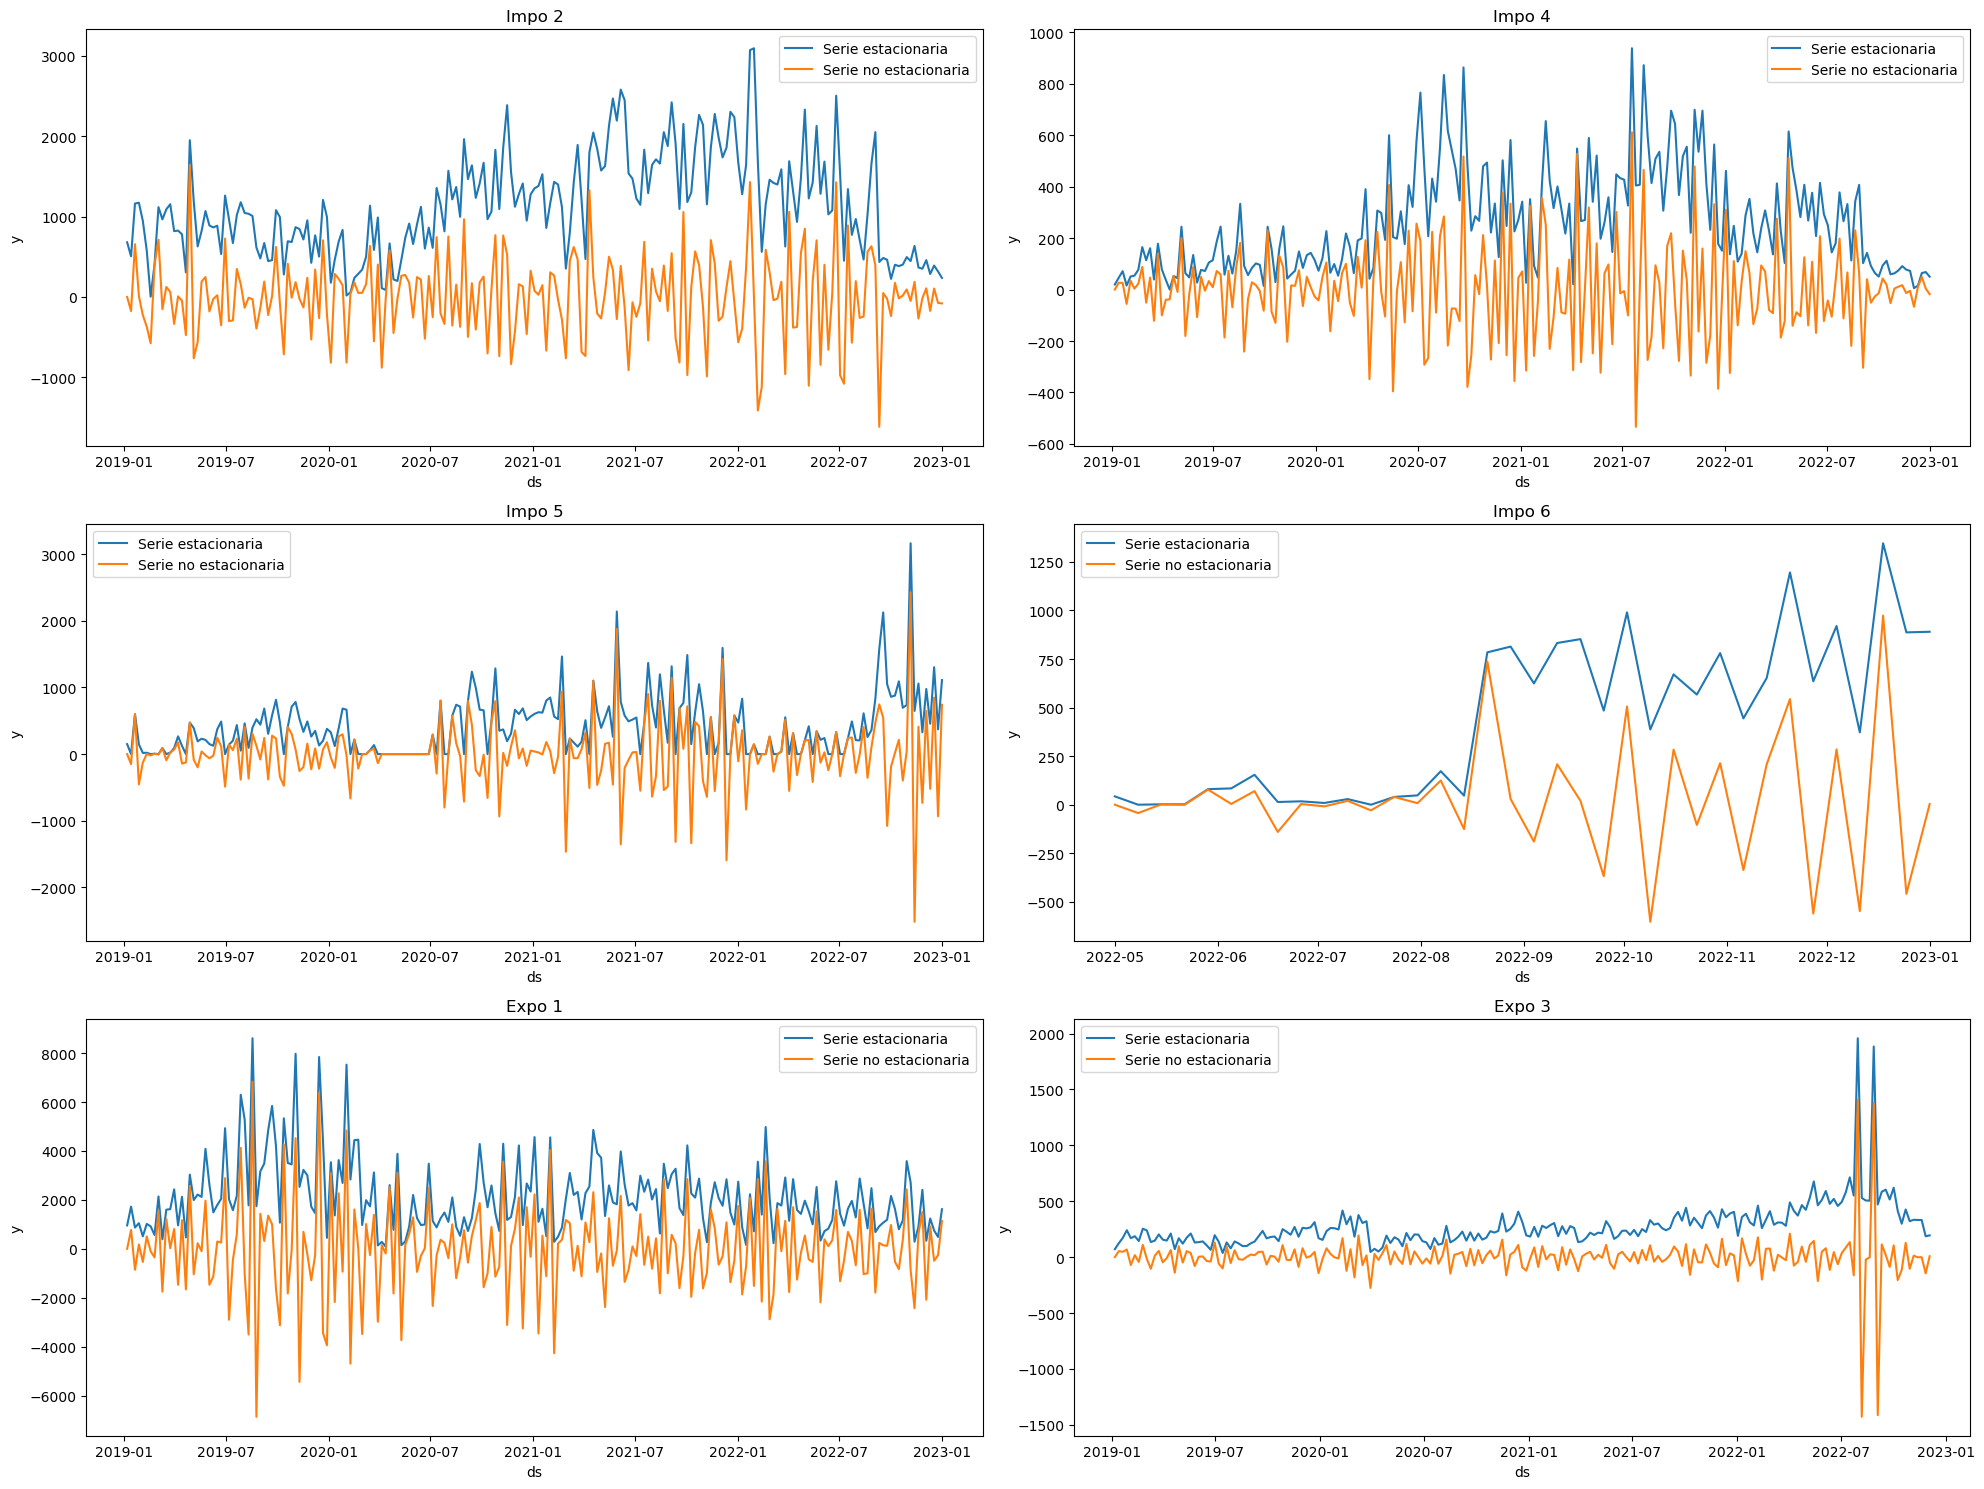

In [17]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

datasets = [
    (df_impo_2, 'Impo 2'), (df_impo_4, 'Impo 4'),
    (df_impo_5, 'Impo 5'), (df_impo_6, 'Impo 6'),
    (df_expo_1, 'Expo 1'), (df_expo_3, 'Expo 3')
]

for i, (data, title) in enumerate(datasets):
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    
    sns.lineplot(data=data, x='ds', y='y', ax=ax, label='Serie estacionaria')
    sns.lineplot(data=data, x='ds', y='y_diff', ax=ax, label='Serie no estacionaria')
    
    ax.set_title(f'{title}')
    ax.legend() 

plt.tight_layout()


plt.show()


#### Test ACF y PACF para series no estacionarias

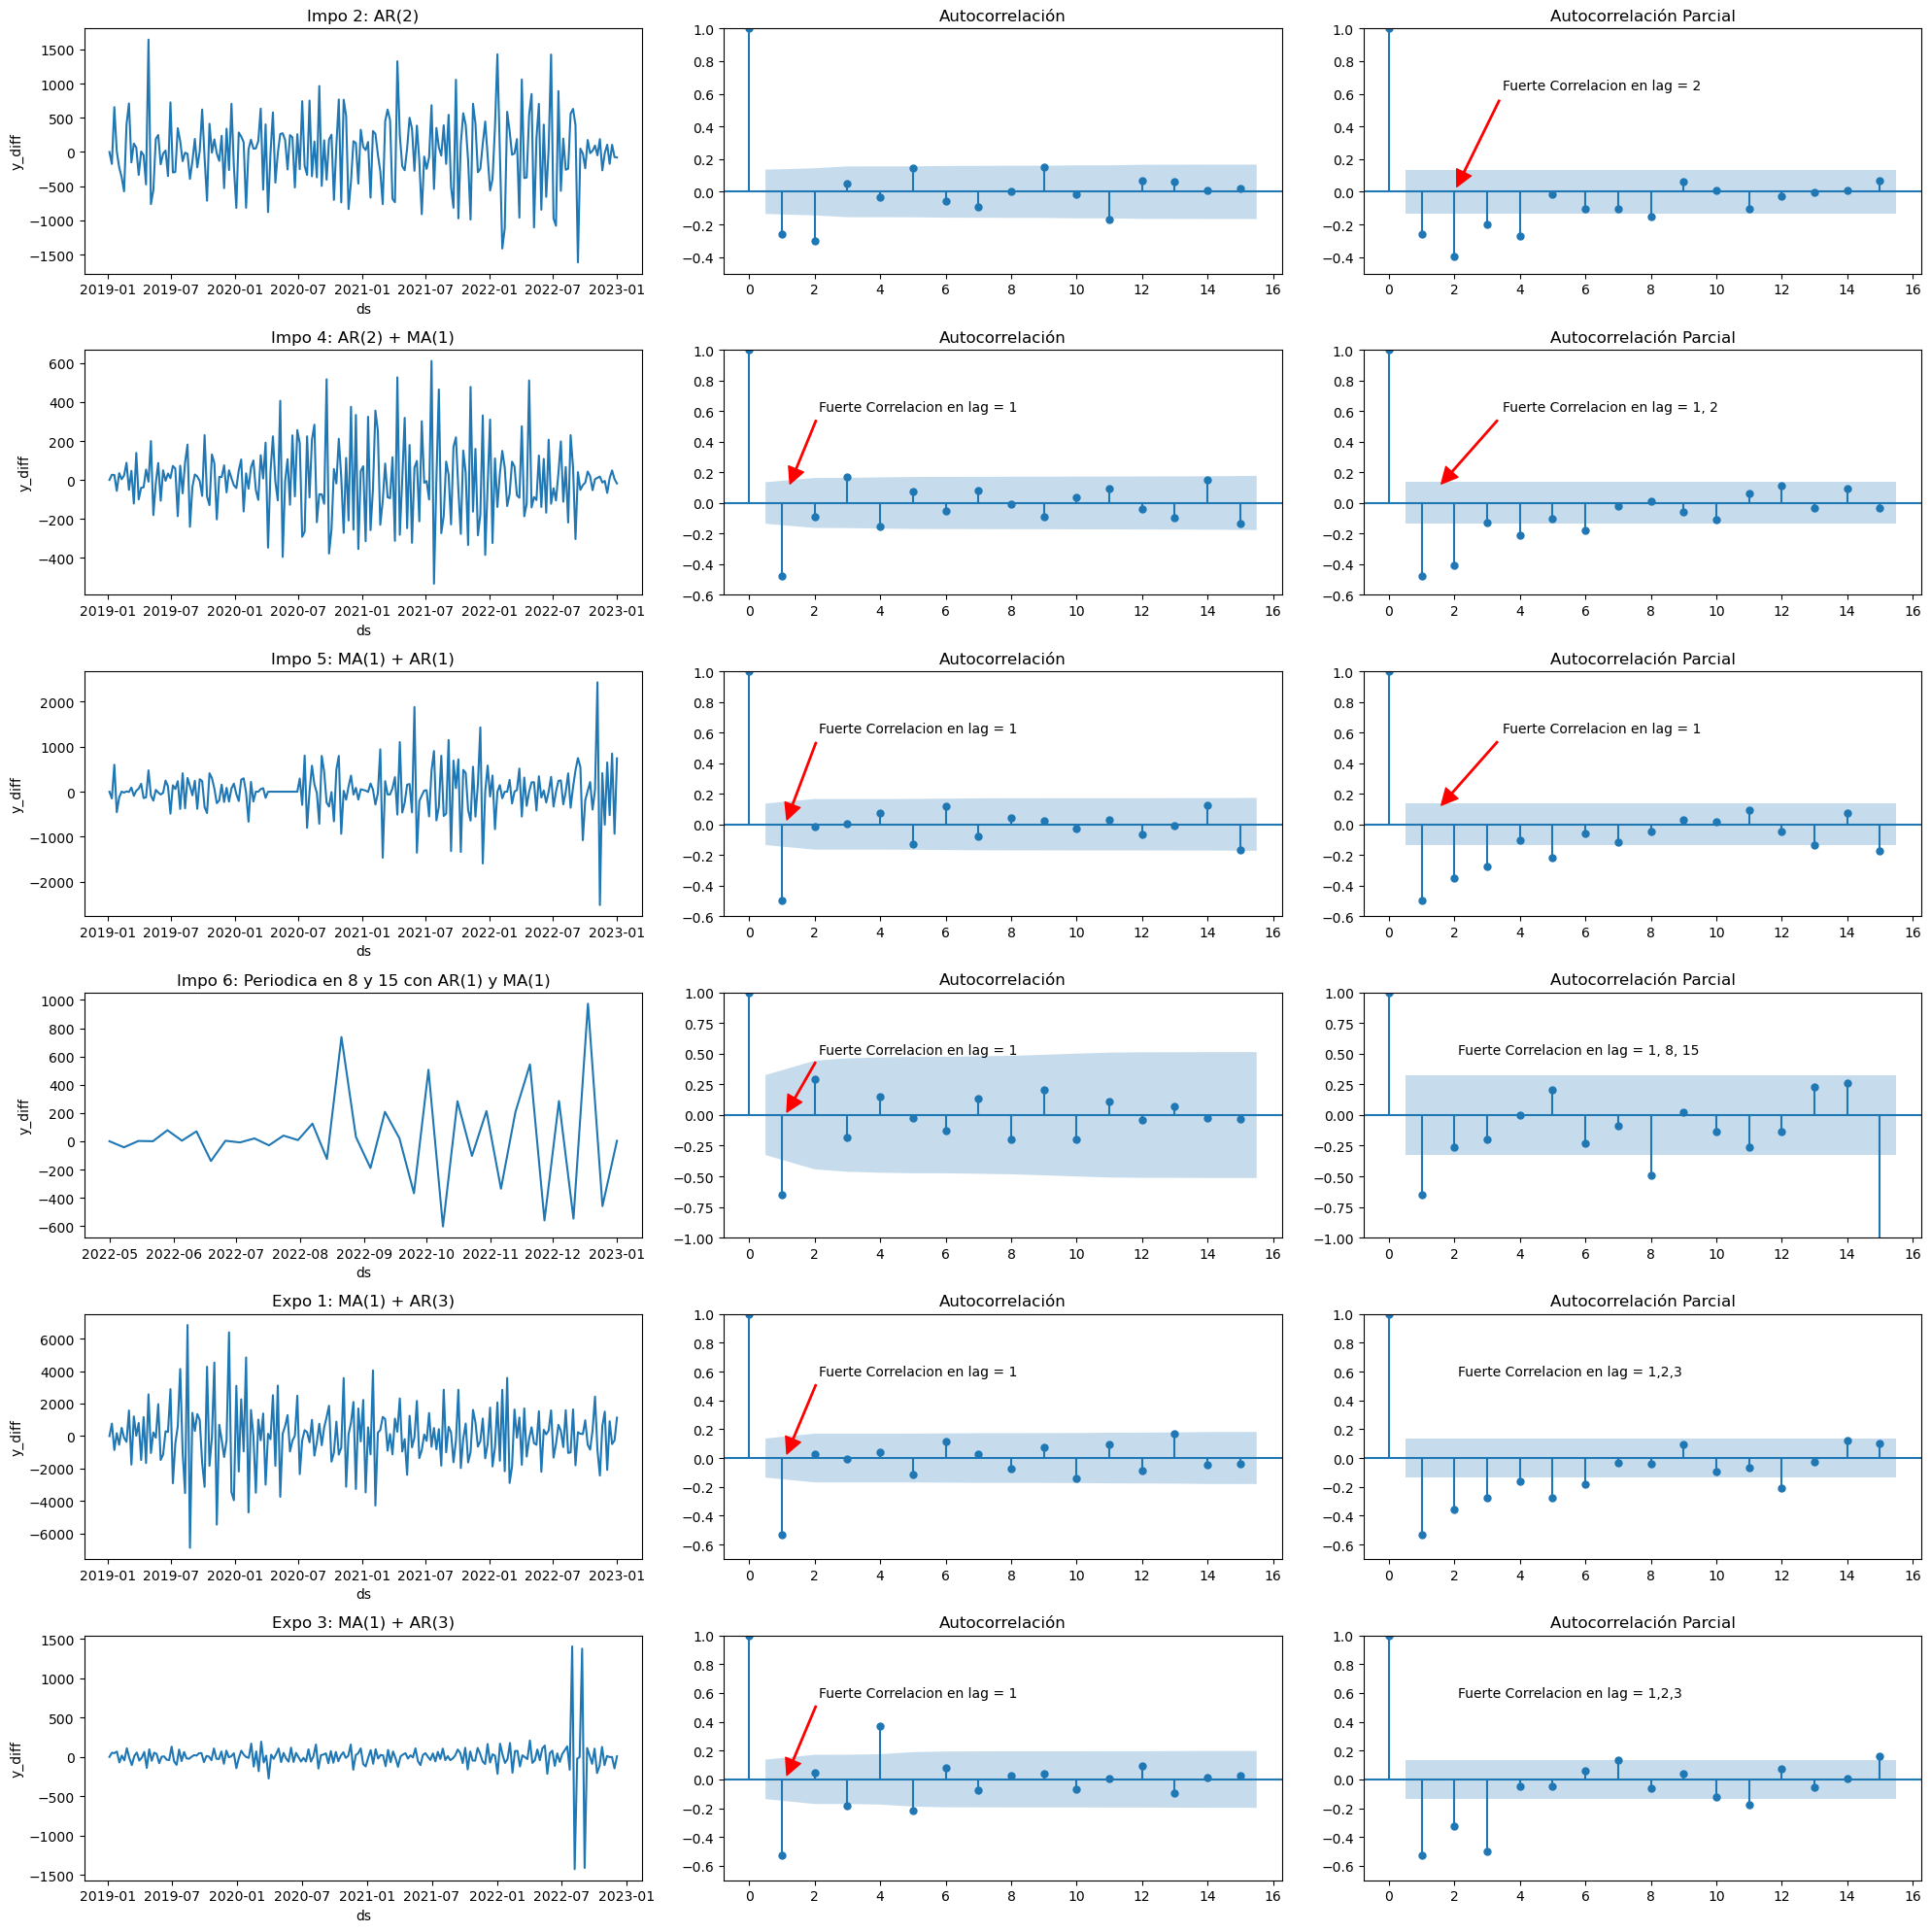

In [18]:

width = 20
height = 10
lag_acf = 15
lag_pacf = 15

f, ax = plt.subplots(nrows=6, ncols=3, figsize=(width, 2 * height))

##### Impo 2

# Graficar la serie de tiempo
sns.lineplot(x=df_impo_2['ds'], y=df_impo_2['y_diff'], ax=ax[0, 0])
ax[0, 0].set_title('Impo 2: AR(2)')

# Graficar ACF
plot_acf(df_impo_2['y_diff'], lags=lag_acf, ax=ax[0, 1])
ax[0, 1].set_ylim(-0.5, 1)
ax[0, 1].set_title('Autocorrelación')

# Graficar PACF 
plot_pacf(df_impo_2['y_diff'], lags=lag_pacf, ax=ax[0, 2], method='ols')
ax[0, 2].set_ylim(-0.5, 1)
ax[0, 2].set_title('Autocorrelación Parcial')
ax[0, 2].annotate('Fuerte Correlacion en lag = 2', xy=(2,- 0), xycoords='data',
               xytext=(0.25,0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))

##### Impo 4

# Graficar la serie de tiempo para Impo 3
sns.lineplot(x=df_impo_4['ds'], y=df_impo_4['y_diff'], ax=ax[1, 0])
ax[1, 0].set_title('Impo 4: AR(2) + MA(1)')  # Ajusta el título según corresponda

# Graficar ACF para Impo 4
plot_acf(df_impo_4['y_diff'], lags=lag_acf, ax=ax[1, 1])
ax[1, 1].set_ylim(-0.6, 1)
ax[1, 1].set_title('Autocorrelación')
ax[1, 1].annotate('Fuerte Correlacion en lag = 1', xy=(1.2, 0.1), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))

# Graficar PACF para Impo 4
plot_pacf(df_impo_4['y_diff'], lags=lag_pacf, ax=ax[1, 2], method='ols')
ax[1, 2].set_ylim(-0.6, 1)
ax[1, 2].set_title('Autocorrelación Parcial')
ax[1, 2].annotate('Fuerte Correlacion en lag = 1, 2', xy=(1.5,0.1), xycoords='data',
               xytext=(0.25,0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))

##### Impo 5

# Graficar la serie de tiempo para Impo 5
sns.lineplot(x=df_impo_5['ds'], y=df_impo_5['y_diff'], ax=ax[2, 0])
ax[2, 0].set_title('Impo 5: MA(1) + AR(1)')  # Ajusta el título según corresponda

# Graficar ACF para Impo 5
plot_acf(df_impo_5['y_diff'], lags=lag_acf, ax=ax[2, 1])
ax[2, 1].set_ylim(-0.6, 1)
ax[2, 1].set_title('Autocorrelación')
ax[2, 1].annotate('Fuerte Correlacion en lag = 1', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction', 
               arrowprops=dict(color='red', shrink=0.05, width=1))

# Graficar PACF para Impo 5
plot_pacf(df_impo_5['y_diff'], lags=lag_pacf, ax=ax[2, 2], method='ols')
ax[2, 2].set_ylim(-0.6, 1)
ax[2, 2].set_title('Autocorrelación Parcial')
ax[2, 2].annotate('Fuerte Correlacion en lag = 1', xy=(1.5,0.1), xycoords='data',
               xytext=(0.25,0.75), textcoords='axes fraction',
               arrowprops=dict(color='red', shrink=0.05, width=1))


##### Impo 6

# Graficar la serie de tiempo para Impo 6
sns.lineplot(x=df_impo_6['ds'], y=df_impo_6['y_diff'], ax=ax[3, 0])
ax[3, 0].set_title('Impo 6: Periodica en 8 y 15 con AR(1) y MA(1)')  

# Graficar ACF para Impo 6
plot_acf(df_impo_6['y_diff'], lags=lag_acf, ax=ax[3, 1])

ax[3, 1].set_title('Autocorrelación')
ax[3, 1].annotate('Fuerte Correlacion en lag = 1', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction', 
               arrowprops=dict(color='red', shrink=0.05, width=1))

# Graficar PACF para Impo 6
plot_pacf(df_impo_6['y_diff'], lags=lag_pacf, ax=ax[3, 2], method='ols')

ax[3, 2].set_title('Autocorrelación Parcial')
ax[3, 2].annotate('Fuerte Correlacion en lag = 1, 8, 15', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction')


##### Expo 1

# Graficar la serie de tiempo para Expo 1
sns.lineplot(x=df_expo_1['ds'], y=df_expo_1['y_diff'], ax=ax[4, 0])
ax[4, 0].set_title('Expo 1: MA(1) + AR(3)')  

# Graficar ACF para Expo 1
plot_acf(df_expo_1['y_diff'], lags=lag_acf, ax=ax[4, 1])
ax[4, 1].set_ylim(-0.7, 1)
ax[4, 1].set_title('Autocorrelación')
ax[4, 1].annotate('Fuerte Correlacion en lag = 1', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction', 
               arrowprops=dict(color='red', shrink=0.05, width=1))

# Graficar PACF para Expo 1
plot_pacf(df_expo_1['y_diff'], lags=lag_pacf, ax=ax[4, 2], method='ols')
ax[4, 2].set_ylim(-0.7, 1)
ax[4, 2].set_title('Autocorrelación Parcial')
ax[4, 2].annotate('Fuerte Correlacion en lag = 1,2,3', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction')

##### Expo 3

# Graficar la serie de tiempo para Expo 3
sns.lineplot(x=df_expo_3['ds'], y=df_expo_3['y_diff'], ax=ax[5, 0])
ax[5, 0].set_title('Expo 3: MA(1) + AR(3)')  

# Graficar ACF para Expo 3
plot_acf(df_expo_3['y_diff'], lags=lag_acf, ax=ax[5, 1])
ax[5, 1].set_ylim(-0.7, 1)
ax[5, 1].set_title('Autocorrelación')
ax[5, 1].annotate('Fuerte Correlacion en lag = 1', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction', 
               arrowprops=dict(color='red', shrink=0.05, width=1))

# Graficar PACF para Expo 3
plot_pacf(df_expo_3['y_diff'], lags=lag_pacf, ax=ax[5, 2], method='ols')
ax[5, 2].set_ylim(-0.7, 1)
ax[5, 2].set_title('Autocorrelación Parcial')
ax[5, 2].annotate('Fuerte Correlacion en lag = 1,2,3', xy=(1.1, 0), xycoords='data',
               xytext=(0.17, 0.75), textcoords='axes fraction')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

De acuerdo a los resultados obtenidos para los test de autocorrelacion, y autocorrelacion parcial, podemos definir que tipo de modelo podria utilizarse para cada serie tal como se especifica en los titulos de las serie en los plot. 


A modo de resumen los resultados obtenidos fueron: 

- Impo 2: AR(2). 

        Presenta una fuerte autocorrelacion parcial en el lag 2, notese que para ambos test se obtienen correlaciones negativas lo que implica que hay una correlacion directa negativa entre el lag 2 y el 0. Es decir, si hace dos semanas la serie presento un aumento significativo en esta semana habra una disminucion significativa en la cantidad de kilos, lo que sucede dos semanas previas a la semana de analisis provocara un efecto contrario en la semana 0. 

- Impo 4: MA(1) o bien AR(2).

        Esta serie presenta una fuerte autocorrelacion en el lag 1 y una fuerte autocorrelacion parcial paralos lags 1 y 2, por lo que debemos testear ambos modelos para reconocer cual es el mas adecuado. 

- Impo 5: MA(1), o bien AR(1). 

        Presenta una fuerte correlacion del lag 1 para ambos tests, por lo que tanto un modelo AR como MA podrian modelar la serie, en la siguiente seccion evaluaremos cada uno. 

- Impo 6: Periodica en 8 y 15, MA(1) y AR(1)

        Segun el resultado del test PACF podemos afirmar que presenta una correlacion directa el lag 8 y 15 con el lag 0, esto quiere decir que puede existir cierta periodicidad en la serie debido a esta relacion. Por otro lado tambien se observan fuertes correlaciones en el lag para ambos tests, lo que implica que un modelo MA(1) o AR(1) podrian modelar el comportamiento de la serie. 

- Expo 1: MA(1) + AR(3)

        Para el test de autocorrelacion la serie presenta un fuerte correlacion en el lag 1 por lo que un modelo MA(1) podria modelar la serie, pero por otro lado tambien presenta para el test PACF una fuerte correlacion en los lags 1,2 y 3 por lo que tambien se podria utilizar un modelo AR(3)

#### Modelado SARIMAX

De acuerdo a los resultados obtenidos, podemos observar que cada serie presenta sus particularidades y patrones especificos por lo que para facilitar la comparacion y el analisis de modelos para cada una de las series, seleccione cuatro modelos estadisticos clásicos: AR, MA, ARMA y ARIMA. Los entrenaré y compararé para cada serie, y para facilitar la comparación aplicaré los mismos modelos a todas las series para evaluar su comportamiento.

Notese que anteriormente en el analisis define cuales serian los modelos apropiados para cada serie de acuerdo a la teoria, sin embargo en esta sección probare estos cuatro modelos sobre todas las series independientemente de los resultados previos. Aun asi lo que tendre en cuenta son los lags obtenidos ya que con ellos tuneare el modelo para cada serie. Asimismo, utilizaré el modelo SARIMAX de la libreria statsmodels. 

#### Funciones útiles: modelado estadistico clásico


https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

Autoregressive Integrated Moving Average (ARIMA) model, and extensions

This model is the basic interface for ARIMA-type models, including those with exogenous regressors and those with seasonal components. 

The most general form of the model is SARIMAX(p, d, q)x(P, D, Q, s). It also allows all specialized cases, including

- autoregressive models: AR(p)

- moving average models: MA(q)

- mixed autoregressive moving average models: ARMA(p, q)

- integration models: ARIMA(p, d, q)

- seasonal models: SARIMA(P, D, Q, s)

- regression with errors that follow one of the above ARIMA-type models




Three integers (p, d, q) are typically used to parametrize ARIMA models.

p: number of autoregressive terms (AR order)

d: number of nonseasonal differences (differencing order)

q: number of moving-average terms (MA order)



The ARIMA (aka Box-Jenkins) model adds differencing to an ARMA model. Differencing subtracts the current value from the previous and can be used to transform a time series into one that’s stationary. For example, first-order differencing addresses linear trends, and employs the transformation zi = yi — yi-1. Second-order differencing addresses quadratic trends and employs a first-order difference of a first-order difference, namely zi = (yi — yi-1) — (yi-1 — yi-2), and so on.

In [19]:
def sarimax_model(df, order,seasonal_order,  motivo, comparison_tbl):
    
    #queremos saber cuanto tiempo de procesamiento lleva correr cada modelo para eso usamos el time.clock 
    tic = time.clock()
    
    num_samples= len(df)
    train_len = int(0.8* num_samples)
    
    train = df['y'][:train_len]
    ma_model =  sm.tsa.statespace.SARIMAX(train,
                                          order=order, 
                                          seasonal_order=seasonal_order).fit()

    print(ma_model.summary())
    pred = ma_model.predict(start=train_len, end=num_samples, dynamic=False)
    
    
    actual_values = df['y'][train_len -1:]
    predicted_values = pred
    
    #definimos las metricas con las que vamos a evaluar la performance 
    
    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    smape = calculate_smape(actual_values, predicted_values)
    toc =  time.clock() #frenamos el cronometro y a continuacion creamos la variable que guarda el tiempo transcurrido desde que empezo a correr el modelo hasta q termino
    exetime = '{0:.4f}'.format(toc-tic)
    
    
    # creamos un diccionario donde guardar las variables y resultados del modelo que corrimos
    raw_data = {
            'Serie': motivo,
            'Modelo': f'SARIMAX {order}',
            'MAE':  mae ,
            'RMSE': rmse,
            'sMAPE': smape, 
            'Processing Time': exetime
            }
    
     #creamos un df de una sola row correspondiente a los datos del modelo corrido         
    df_tbl = pd.DataFrame(raw_data,
        columns =['Serie','Modelo','MAE','RMSE', 'sMAPE', 'Processing Time'],
        index = [i_index + 1])
    #le hacemos un append al df que ya definimos afuera de la funcion y que sera ingresado como input, de esta forma cada vez q corremos un modelo los datos se guardan en una nueva linea sin afectar los datos anteriores.
    
    comparison_tbl = pd.concat([comparison_tbl, df_tbl], ignore_index=True)
    
    #graficamos los resultados obtenidos 
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    sns.lineplot(x=df.ds[train_len:num_samples], y=df.y[train_len:num_samples], marker='o', label='test', color='grey')
    sns.lineplot(x=df.ds[:train_len], y=train, marker='o', label='train')
    sns.lineplot(x=df.ds[train_len:num_samples], y=pred, marker='o', label='pred')
    ax.set_xlim([df.ds.iloc[0], df.ds.iloc[-1]])
    ax.set_title(f'{motivo}: SARIMAX {order} Model')
    plt.tight_layout()
    plt.show()
    
    return comparison_tbl

#### Param Grid Search - SARIMAX

In [20]:
### Import Packages ###

import itertools
import statsmodels.api as sm

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit(maxiter=maxiter) 
                print(output)
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    print(ans_df)

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:5]
    
    return ans_df



sarimax_gridsearch(df_impo_1.y, pdq, pdqs)

#### SARIMAX Model
Usando la libreria statsmodels utilizando el modelo SARIMAX podemos utilizar la informacion obtenida del analisis previo para tunear cada serie segun los lags obtenidos en la prueba de autocorrelacion y autocorrelacion parcial. 


La forma general del modelo es SARIMAX (p,d,q) x (P,D,Q,s): 

- p = numero de terminos autoregresivos AR(p)
- d = orden de diferencia
- q = numero de terminos moving average MA(q)
- s = seasonality

Corremos el modelo para cada serie segun los lags obtenidos de la parte anterior:

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                             SARIMAX Results                                              
Dep. Variable:                                                  y   No. Observations:                  167
Model:             SARIMAX([1, 2, 4, 5, 6], 0, 3)x(1, 1, [1], 12)   Log Likelihood               -1250.972
Date:                                            Mon, 11 Sep 2023   AIC                           2523.945
Time:                                                    13:22:57   BIC                           2557.422
Sample:                                                         0   HQIC                          2537.543
                                                            - 167                                         
Covariance Type:                                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

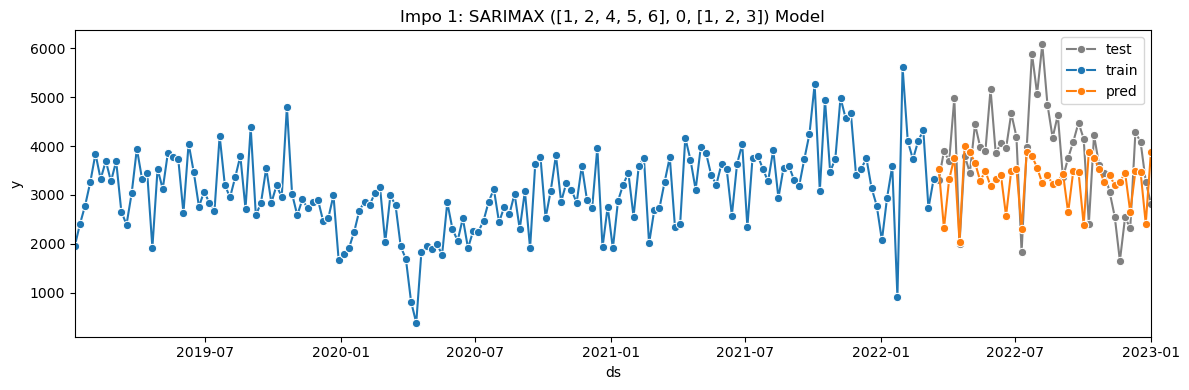

                                            SARIMAX Results                                            
Dep. Variable:                                               y   No. Observations:                  167
Model:             SARIMAX(2, 0, [3, 4, 5])x(1, 1, [1, 2], 12)   Log Likelihood               -1165.370
Date:                                         Mon, 11 Sep 2023   AIC                           2348.740
Time:                                                 13:22:59   BIC                           2376.131
Sample:                                                      0   HQIC                          2359.865
                                                         - 167                                         
Covariance Type:                                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1     

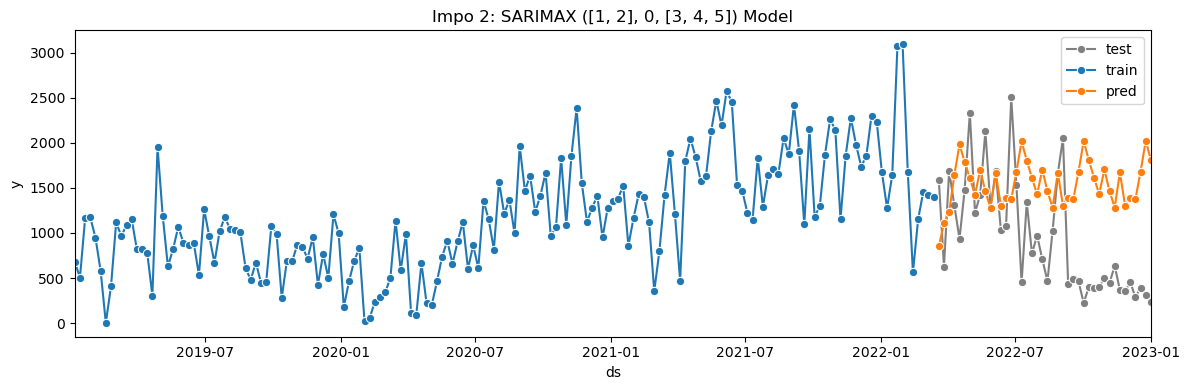

                                        SARIMAX Results                                         
Dep. Variable:                                        y   No. Observations:                  167
Model:             SARIMAX(2, 0, [5])x(2, 1, [1, 2], 9)   Log Likelihood                -897.698
Date:                                  Mon, 11 Sep 2023   AIC                           1811.396
Time:                                          13:23:01   BIC                           1835.897
Sample:                                               0   HQIC                          1821.346
                                                  - 167                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2105      0.074      2.828      0.005       0.065

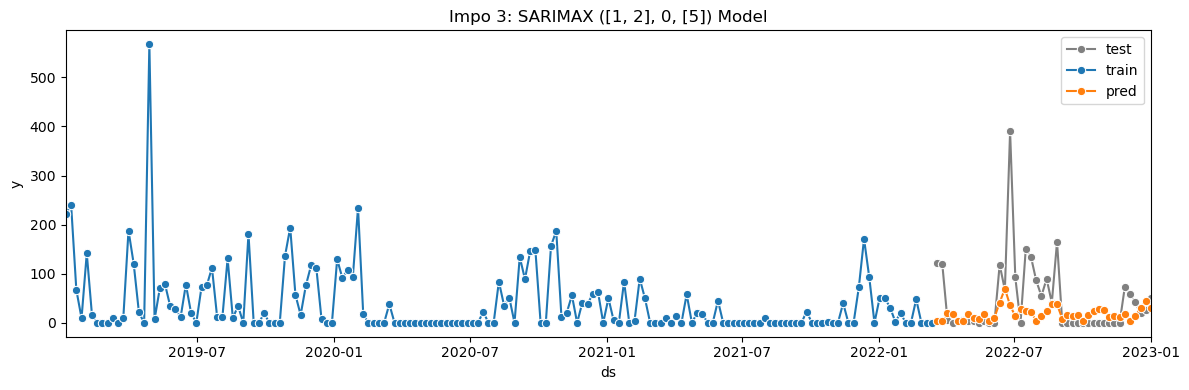

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  167
Model:             SARIMAX([2], 0, 1)x(1, 2, 1, 9)   Log Likelihood               -1026.036
Date:                             Mon, 11 Sep 2023   AIC                           2062.072
Time:                                     13:23:02   BIC                           2077.091
Sample:                                          0   HQIC                          2068.174
                                             - 167                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2          0.1247      0.080      1.558      0.119      -0.032       0.282
ma.L1          0.1650      

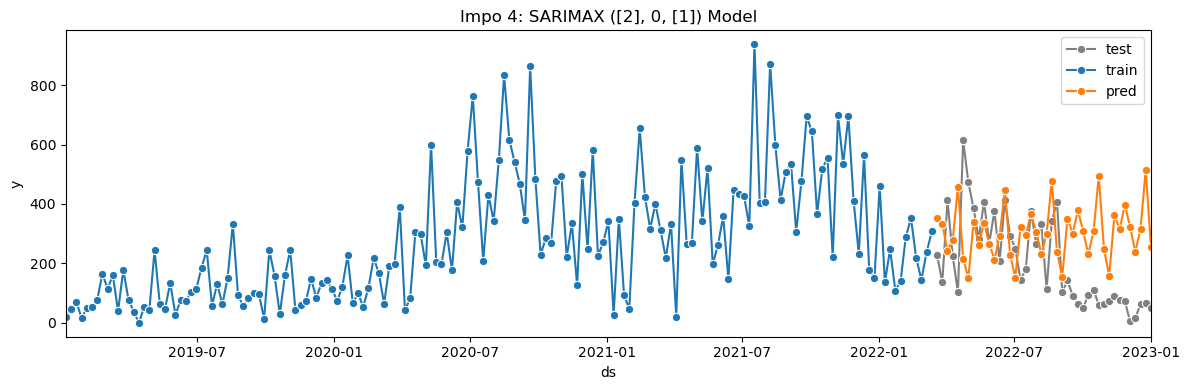

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  167
Model:             SARIMAX([2], 0, [2])x(1, 2, [1, 2], 6)   Log Likelihood               -1164.769
Date:                                    Mon, 11 Sep 2023   AIC                           2341.538
Time:                                            13:23:04   BIC                           2359.799
Sample:                                                 0   HQIC                          2348.955
                                                    - 167                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -1.0000    130.756     -0.008      0

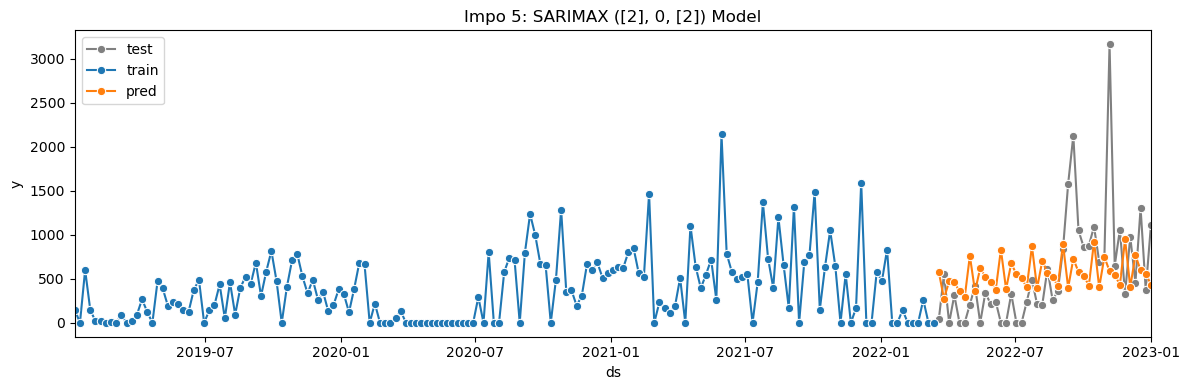

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                   28
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2, 3], 6)   Log Likelihood                -189.900
Date:                                   Mon, 11 Sep 2023   AIC                            393.801
Time:                                           13:23:05   BIC                            403.126
Sample:                                                0   HQIC                           396.652
                                                    - 28                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9219      0.113      8.125      0.000    

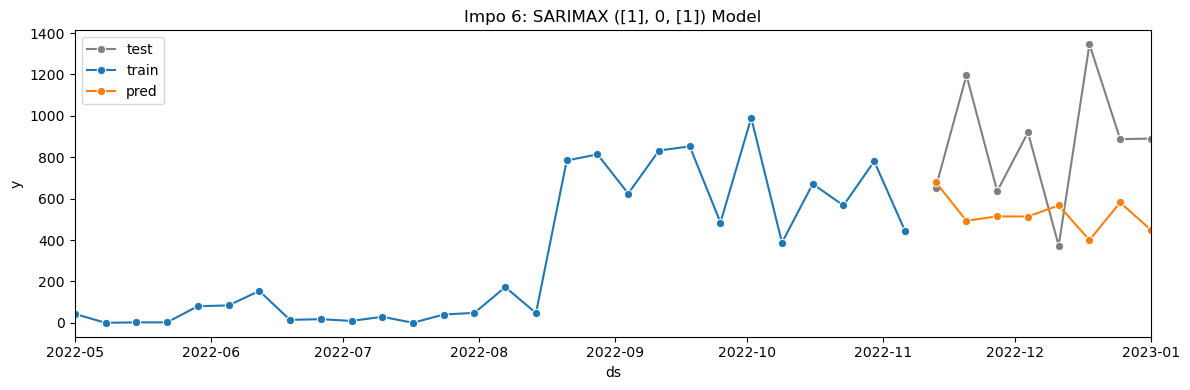

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                                     SARIMAX Results                                                      
Dep. Variable:                                                                  y   No. Observations:                  167
Model:             SARIMAX(2, 0, [10])x(1, 0, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 4)   Log Likelihood               -1059.240
Date:                                                            Mon, 11 Sep 2023   AIC                           2148.480
Time:                                                                    13:23:11   BIC                           2195.250
Sample:                                                                         0   HQIC                          2167.463
                                                                            - 167                                         
Covariance Type:                                                              opg                                         
                

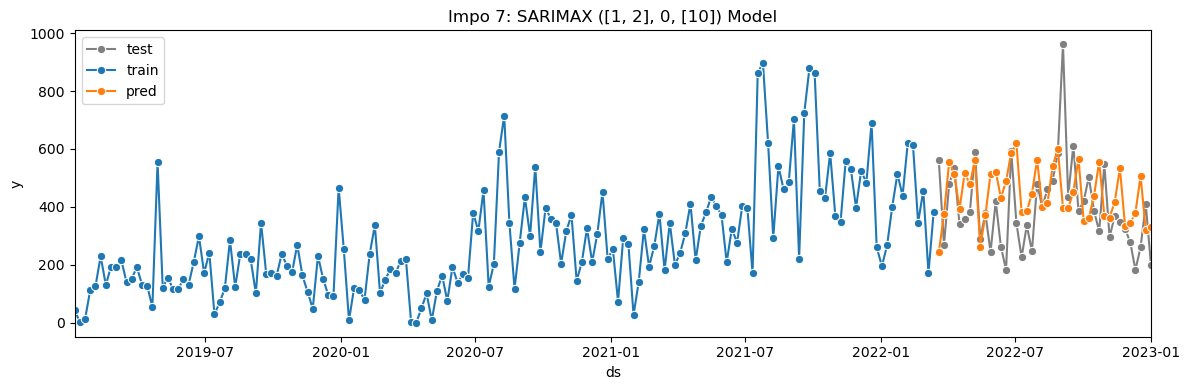

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                  167
Model:             SARIMAX([2], 0, 1)x(1, 2, [1, 2], 11)   Log Likelihood               -1310.620
Date:                                   Mon, 11 Sep 2023   AIC                           2633.239
Time:                                           13:23:14   BIC                           2651.100
Sample:                                                0   HQIC                          2640.497
                                                   - 167                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2          0.1411      0.078      1.799      0.072    

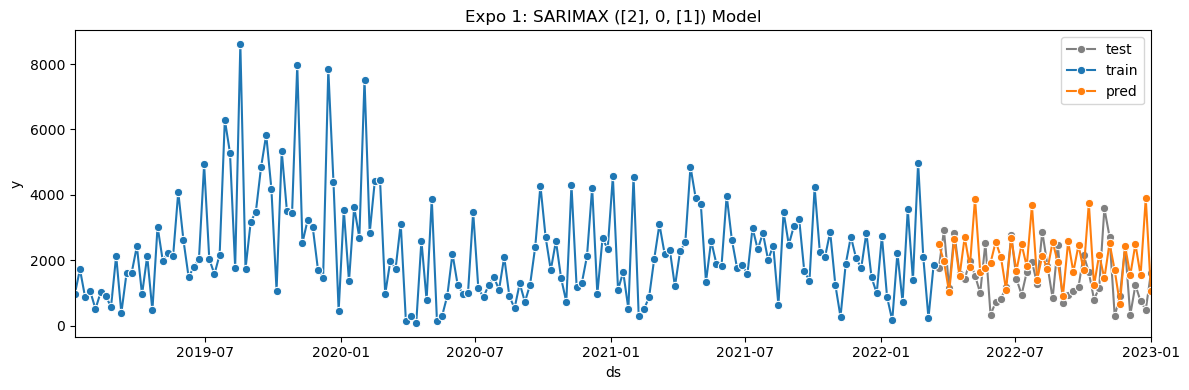

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                  166
Model:             SARIMAX([2], 0, 1)x(1, 2, [1, 2], 11)   Log Likelihood               -1206.033
Date:                                   Mon, 11 Sep 2023   AIC                           2424.066
Time:                                           13:23:16   BIC                           2441.884
Sample:                                                0   HQIC                          2431.306
                                                   - 166                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2          0.0347      0.162      0.215      0.830    

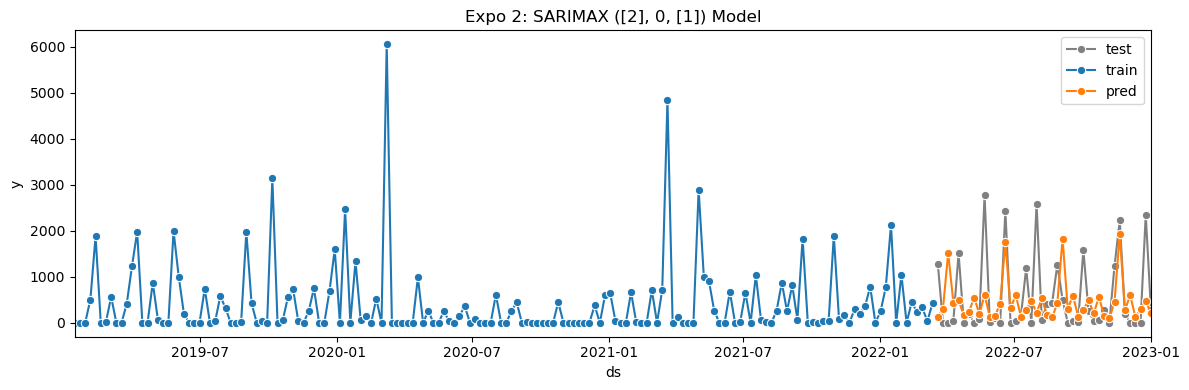

c:\Users\Bravo15\anaconda3\envs\pr_modelado2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                  164
Model:             SARIMAX([3], 0, 1)x(2, 2, [1, 2], 11)   Log Likelihood                -847.207
Date:                                   Mon, 11 Sep 2023   AIC                           1708.413
Time:                                           13:23:19   BIC                           1729.104
Sample:                                                0   HQIC                          1716.821
                                                   - 164                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L3          0.2031      0.089      2.273      0.023    

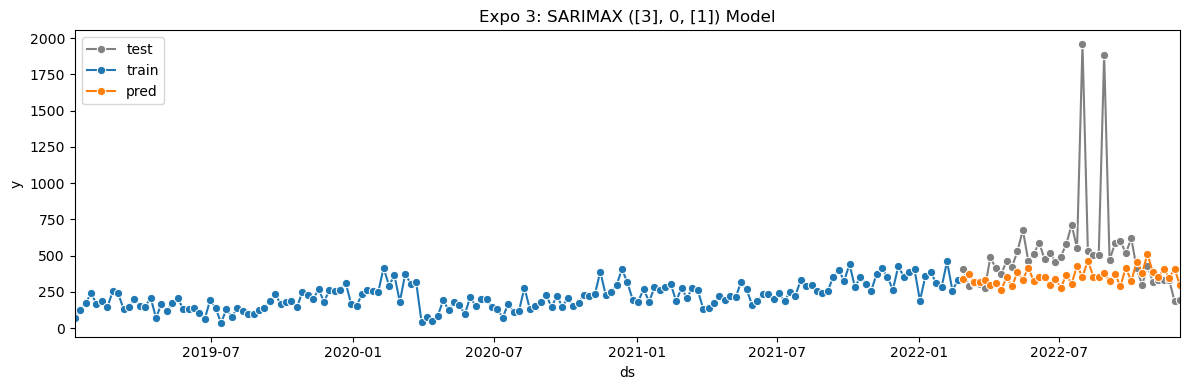

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  167
Model:             SARIMAX(2, 1, [2])x(1, 2, 1, 6)   Log Likelihood               -1031.086
Date:                             Mon, 11 Sep 2023   AIC                           2074.171
Time:                                     13:23:21   BIC                           2092.393
Sample:                                          0   HQIC                          2081.573
                                             - 167                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6999      4.511     -0.155      0.877      -9.541       8.141
ar.L2          0.2996      

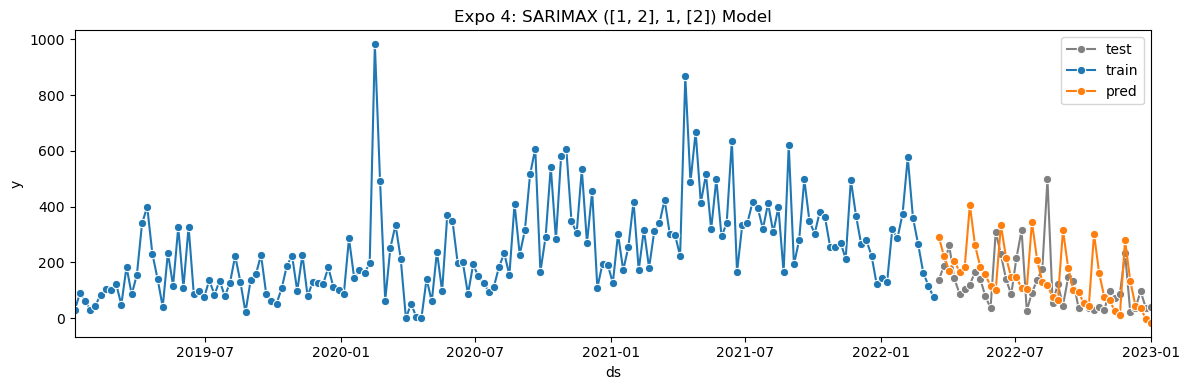

In [21]:
comparison_tbl= sarimax_model(df_impo_1, ([1,2,4,5,6],0,[1,2,3]), (1,1,1,12), 'Impo 1', comparison_tbl)
comparison_tbl= sarimax_model(df_impo_2, ([1,2],0,[3,4,5]),(1,1,2,12), 'Impo 2', comparison_tbl)
comparison_tbl= sarimax_model(df_impo_3, ([1,2],0,[5]),(2,1,2,9), 'Impo 3', comparison_tbl)
comparison_tbl= sarimax_model(df_impo_4, ([2],0,[1]),(1,2,1,9), 'Impo 4', comparison_tbl)
comparison_tbl= sarimax_model(df_impo_5, ([2],0,[2]),(1,2,2,6), 'Impo 5', comparison_tbl)
comparison_tbl= sarimax_model(df_impo_6, ([1],0,[1]),(1,0,3,6), 'Impo 6', comparison_tbl)
comparison_tbl= sarimax_model(df_impo_7, ([1,2],0,[10]),(1,0,10,4), 'Impo 7', comparison_tbl)
comparison_tbl= sarimax_model(df_expo_1, ([2],0,[1]),(1,2,2,11), 'Expo 1', comparison_tbl)
comparison_tbl= sarimax_model(df_expo_2, ([2],0,[1]),(1,2,2,11), 'Expo 2', comparison_tbl)
comparison_tbl= sarimax_model(df_expo_3, ([3],0,[1]),(2,2,2,11), 'Expo 3', comparison_tbl)
comparison_tbl= sarimax_model(df_expo_4, ([1,2],1,[2]),(1,2,1,6), 'Expo 4', comparison_tbl)

Como se puede observar en los resultados obtenidos, utilizando el modelo SARIMAX se puede obtener las variaciones para MA, AR y ARMA. De esta forma, podemos comparar las metricas y los resultados para cada serie. 

In [22]:
comparison_tbl

Serie                                   Modelo          MAE         RMSE  \
0   Impo 1  SARIMAX ([1, 2, 4, 5, 6], 0, [1, 2, 3])  1020.640873  1275.666636   
1   Impo 2           SARIMAX ([1, 2], 0, [3, 4, 5])   814.903721   916.453730   
2   Impo 3                 SARIMAX ([1, 2], 0, [5])    42.912352    77.237038   
3   Impo 4                    SARIMAX ([2], 0, [1])   185.779630   213.952750   
4   Impo 5                    SARIMAX ([2], 0, [2])   413.946660   609.900753   
5   Impo 6                    SARIMAX ([1], 0, [1])   357.309763   428.351523   
6   Impo 7                SARIMAX ([1, 2], 0, [10])   141.687432   183.721246   
7   Expo 1                    SARIMAX ([2], 0, [1])  1081.461875  1263.594024   
8   Expo 2                    SARIMAX ([2], 0, [1])   651.448471   939.710109   
9   Expo 3                    SARIMAX ([3], 0, [1])   199.795894   367.519378   
10  Expo 4                 SARIMAX ([1, 2], 1, [2])    96.732396   137.010334   

       sMAPE Processing Time  
0   0.290936          2.7492  
1   0.728610          2.1479  
2   1.431710          1.9706  
3   0.812257          0.5379  
4   0.859657          1.2911  
5   0.482983          0.3319  
6   0.342107          6.1446  
7   0.612268          2.2186  
8   1.340620          2.6695  
9   0.367942          2.5831  
10  0.726832          0.9695

#### 2. Modelos ML

Para esta sección porbaremos modelar las series de tiempo utilizando tres modelos de ML: LGBM Regressor, XGboost Regressor y Random Forest Regressor. 

Let’s try a seasonal rolling mean, this takes the average over the last n seasons, in this case, it would be the average of the last n Mondays, Tuesdays, etc. Computing the updates for this feature would probably be a bit annoying, however, using this framework we can just pass it to lag_transforms. If the transformations take additional arguments (additional to the values of the series) we specify a tuple like (transform_function, arg1, arg2), which in this case are season_length and window_size.

Nixt libreria 3 modelos sin tuneo de hiperparametros

##### 2.1 Modelado ML simple 
En primera instancia correré los tres modelos de ML sin tuneo de hiperparametros y corriendo cada uno disasociando las series entre si. Cada serie sera entrenada por separada, y cada modelo sera probado por cada serie. En total tres modelos por cada una. A su vez, para simplificar el analisis y la comparacion en esta primer instancia no se realizara un param grid search pero si considerare un window size de 28.

In [23]:
def ml_model(models, df, motivo, comparison_tbl):
    
    #queremos saber cuanto tiempo de procesamiento lleva correr cada modelo para eso usamos el time.clock 
    tic = time.clock()
    
    num_samples= len(df)
    train_len = int(0.8* num_samples)

    df_train = df[:train_len]
    df_test= df[train_len:]

    df_train['unique_id']= 'id_00'
    df_test['unique_id']=  'id_00'
    df_train['static_0']= 72
    df_test['static_0']= 72
    df_train= df_train[['unique_id', 'ds', 'y', 'static_0']]

    fcst = MLForecast(
        models=models,
        freq='W',
        lags=[1, 2],
        lag_transforms={
            1: [expanding_mean],
        },
        target_transforms=[Differences([1])],
    )
    
    fcst.fit(df_train)
    predictions = fcst.predict(len(df_test)) 
    
    actual_values = df['y'][train_len:]
    predicted_values1 = predictions['LGBMRegressor']
    predicted_values2= predictions['XGBRegressor']
    predicted_values3= predictions['RandomForestRegressor']
    
    
    #definimos las metricas con las que vamos a evaluar la performance 
      
    mae1 = mean_absolute_error(actual_values, predicted_values1)
    rmse1 = np.sqrt(mean_squared_error(actual_values, predicted_values1))
    smape1 = calculate_smape(actual_values, predicted_values1)
    
    
    mae2 = mean_absolute_error(actual_values, predicted_values2)
    rmse2 = np.sqrt(mean_squared_error(actual_values, predicted_values2))
    smape2 = calculate_smape(actual_values, predicted_values2)
    
    
    mae3 = mean_absolute_error(actual_values, predicted_values3)
    rmse3 = np.sqrt(mean_squared_error(actual_values, predicted_values3))
    smape3 = calculate_smape(actual_values, predicted_values3)
    
    toc =  time.clock() #frenamos el cronometro y a continuacion creamos la variable que guarda el tiempo transcurrido desde que empezo a correr el modelo hasta q termino
    exetime = '{0:.4f}'.format(toc-tic)
    
    
    # creamos un diccionario donde guardar las variables y resultados del modelo que corrimos
    raw_data1 = {
            'Serie': [motivo, motivo, motivo],
            'Modelo': ['LGBMRegressor','XGBRegressor','RandomForestRegressor'],
            'MAE':  [mae1 ,mae2, mae3],
            'RMSE': [rmse1,rmse2, rmse3],
            'sMAPE': [smape1,smape2, smape3], 
            'Processing Time': [exetime, exetime, exetime],
            }
    
     #creamos un df de una sola row correspondiente a los datos del modelo corrido         
    df_tbl = pd.DataFrame(raw_data1)
    #le hacemos un append al df que ya definimos afuera de la funcion y que sera ingresado como input, de esta forma cada vez q corremos un modelo los datos se guardan en una nueva linea sin afectar los datos anteriores.
    comparison_tbl = pd.concat([comparison_tbl, df_tbl], ignore_index=True)
    
    #graficamos los resultados obtenidos 
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    sns.lineplot(x=df.ds[train_len:num_samples], y=df.y[train_len:num_samples], marker='o', label='test', color='grey')
    sns.lineplot(x=df.ds[:train_len], y=df_train.y, marker='o', label='train')
    sns.lineplot(x=predictions.ds, y=predictions['LGBMRegressor'], marker='o', label='pred')
    ax.set_xlim([df.ds.iloc[0], df.ds.iloc[-1]])
    ax.set_title(f'{motivo}: LGBMRegressor Model')
    plt.tight_layout()
    plt.show()
    
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    sns.lineplot(x=df.ds[train_len:num_samples], y=df.y[train_len:num_samples], marker='o', label='test', color='grey')
    sns.lineplot(x=df.ds[:train_len], y=df_train.y, marker='o', label='train')
    sns.lineplot(x=predictions.ds, y=predictions['XGBRegressor'], marker='o', label='pred')
    ax.set_xlim([df.ds.iloc[0], df.ds.iloc[-1]])
    ax.set_title(f'{motivo}: XGBRegressor Model')
    plt.tight_layout()
    plt.show()
    
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    sns.lineplot(x=df.ds[train_len:num_samples], y=df.y[train_len:num_samples], marker='o', label='test', color='grey')
    sns.lineplot(x=df.ds[:train_len], y=df_train.y, marker='o', label='train')
    sns.lineplot(x=predictions.ds, y=predictions['RandomForestRegressor'], marker='o', label='pred')
    ax.set_xlim([df.ds.iloc[0], df.ds.iloc[-1]])
    ax.set_title(f'{motivo}: RandomForestRegressor Model')
    plt.tight_layout()
    plt.show()
    
    
    return comparison_tbl

In [24]:
models = [
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

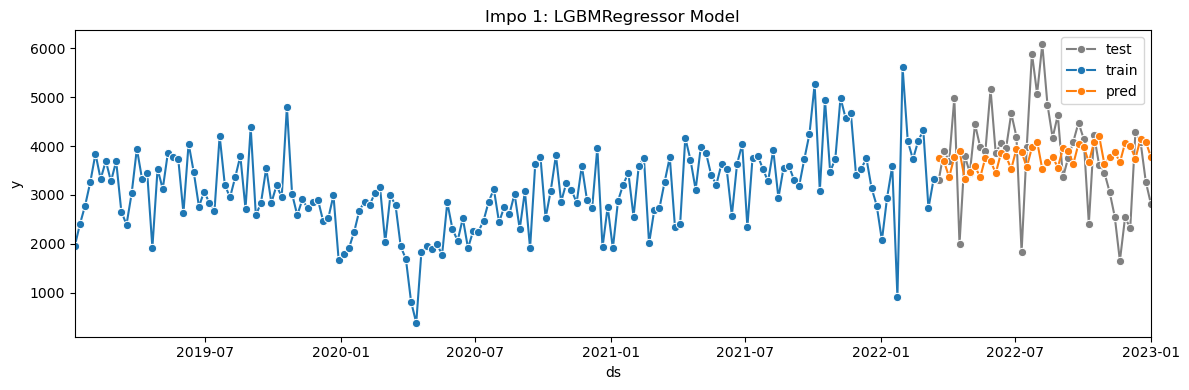

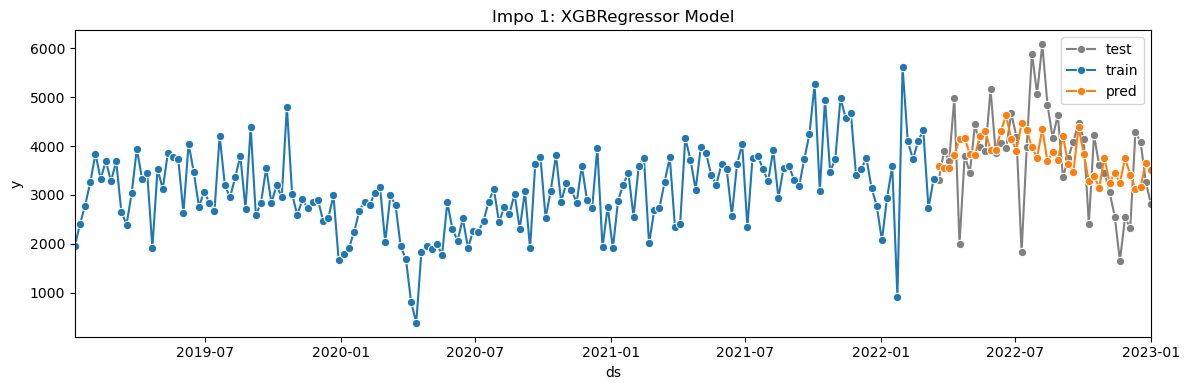

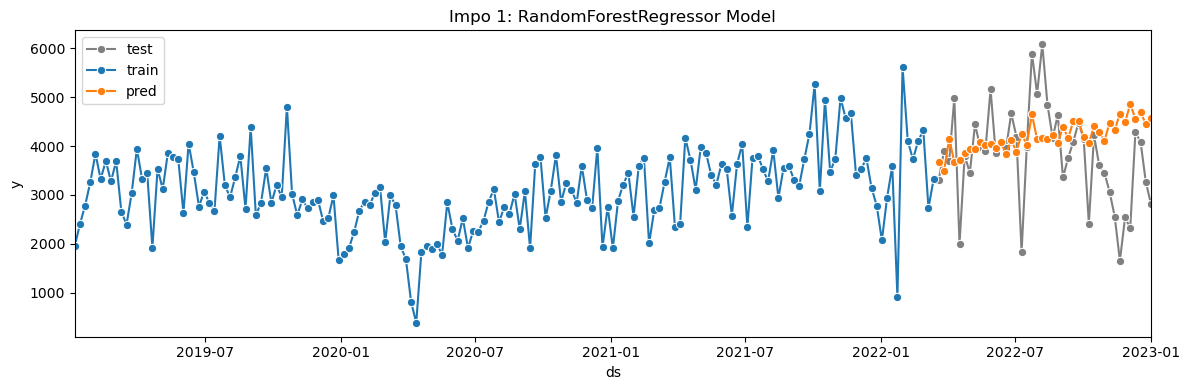

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

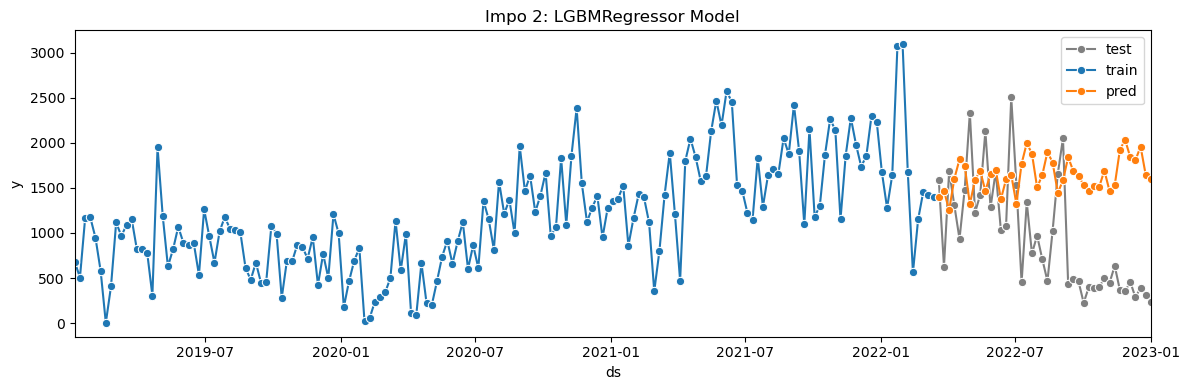

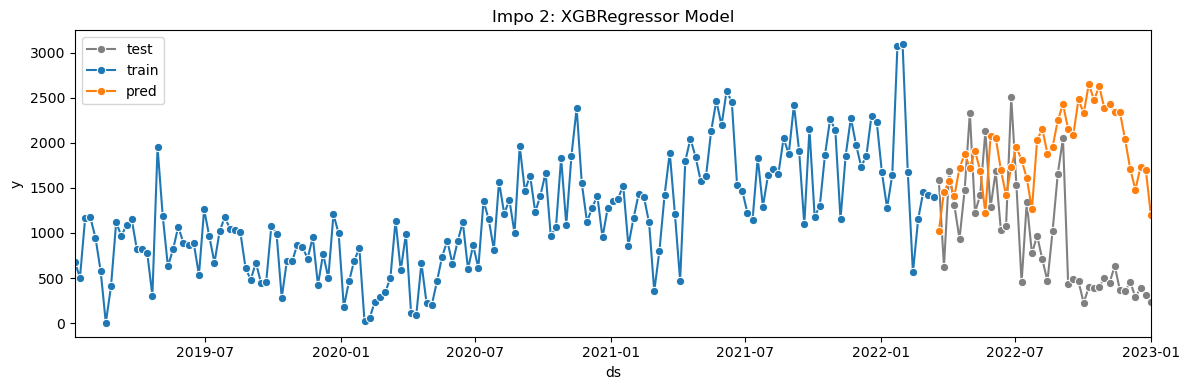

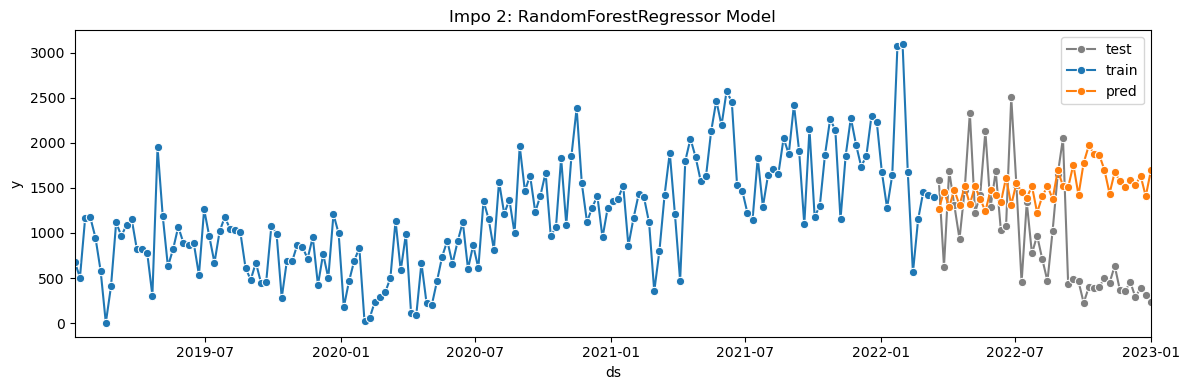

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

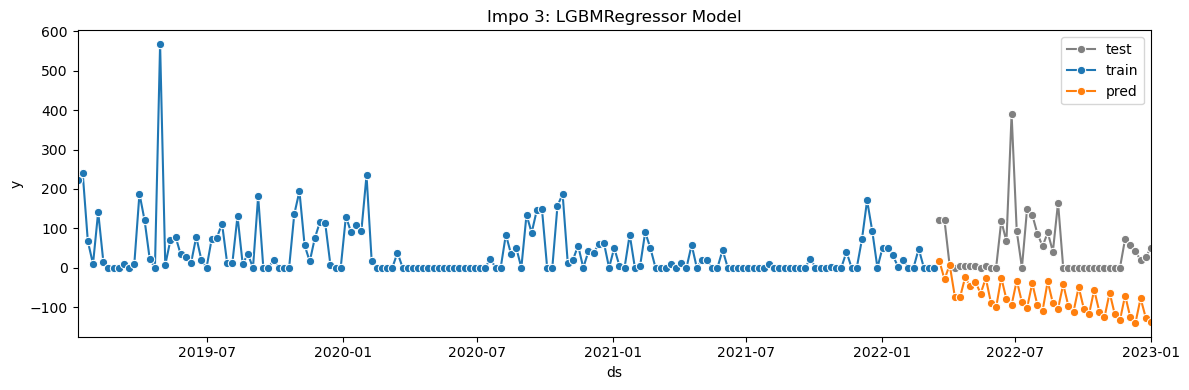

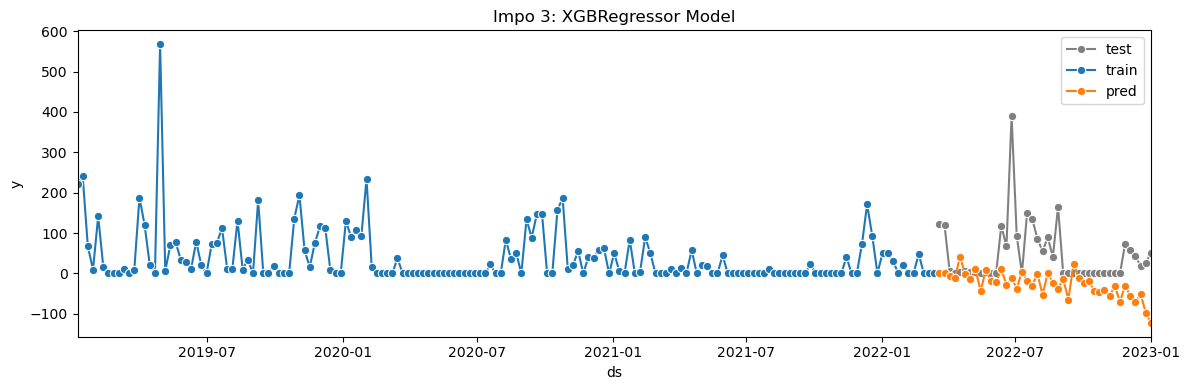

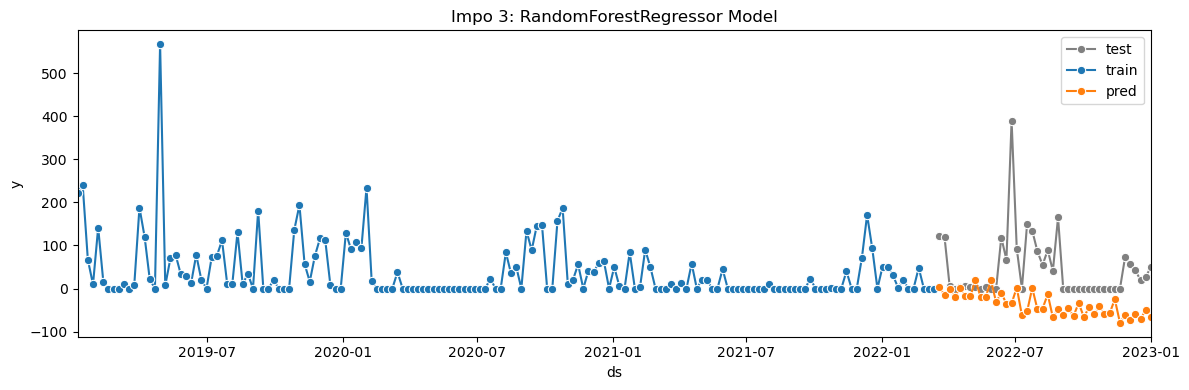

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

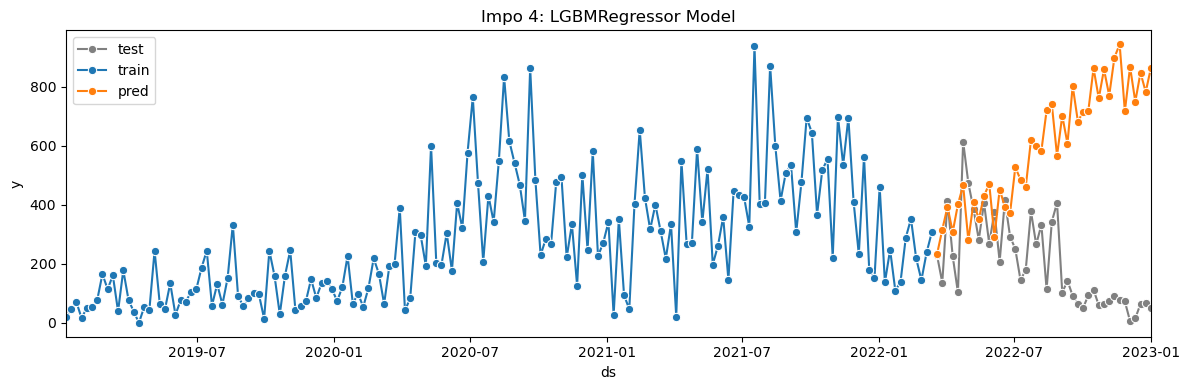

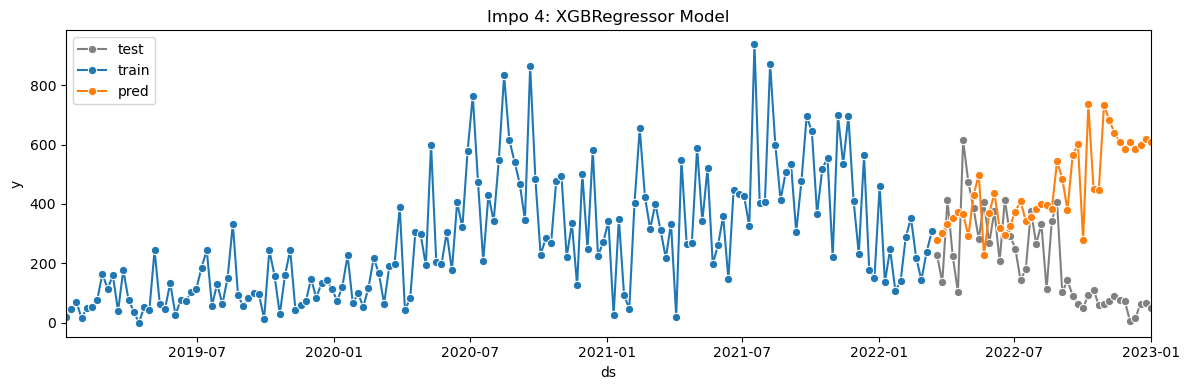

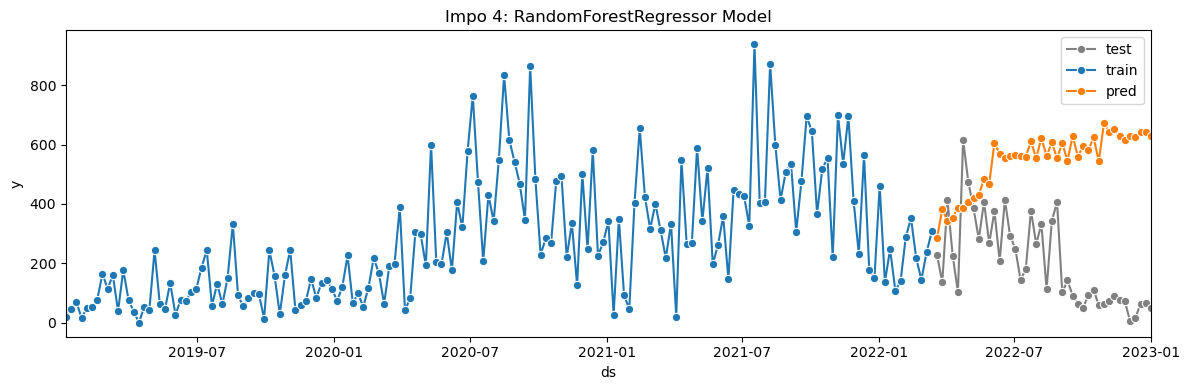

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

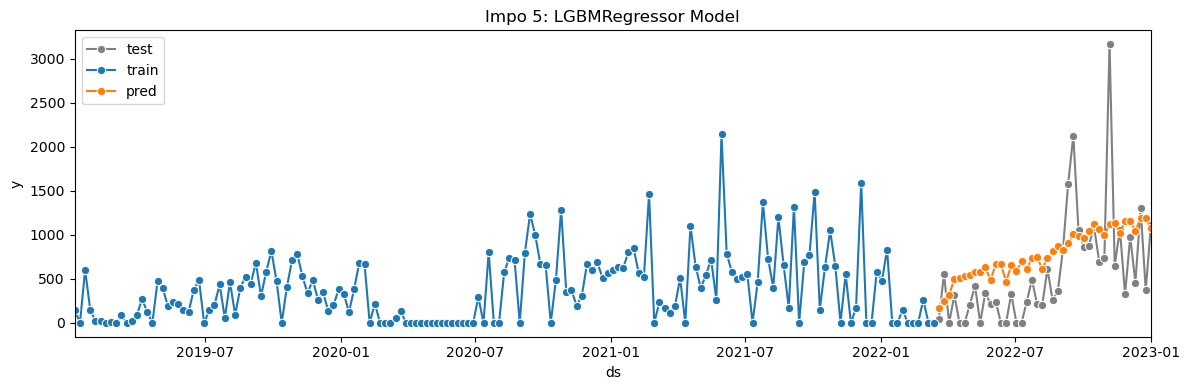

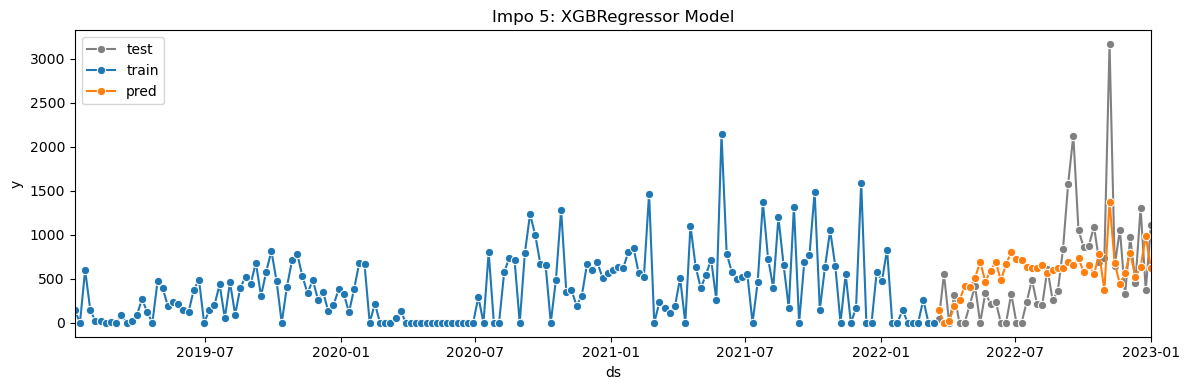

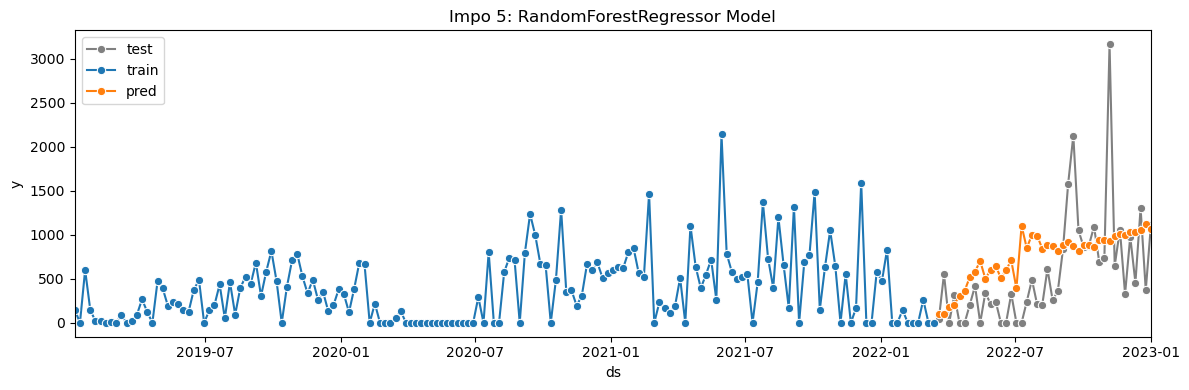

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

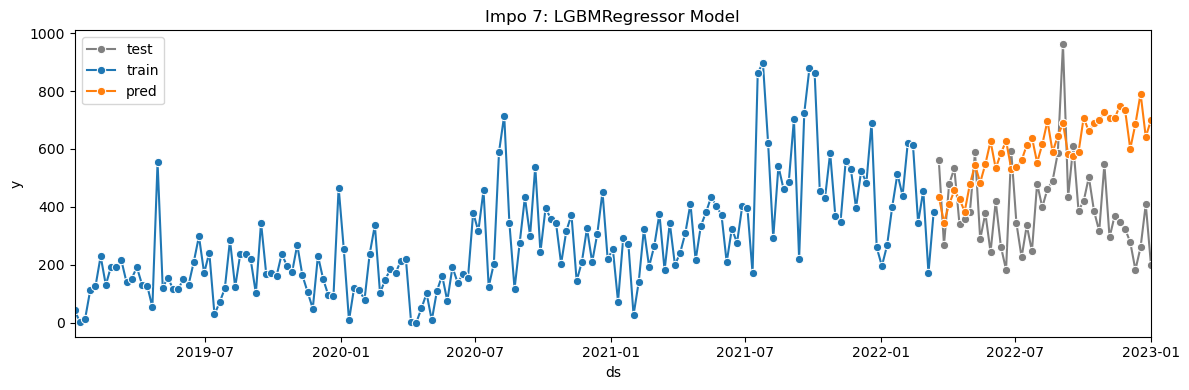

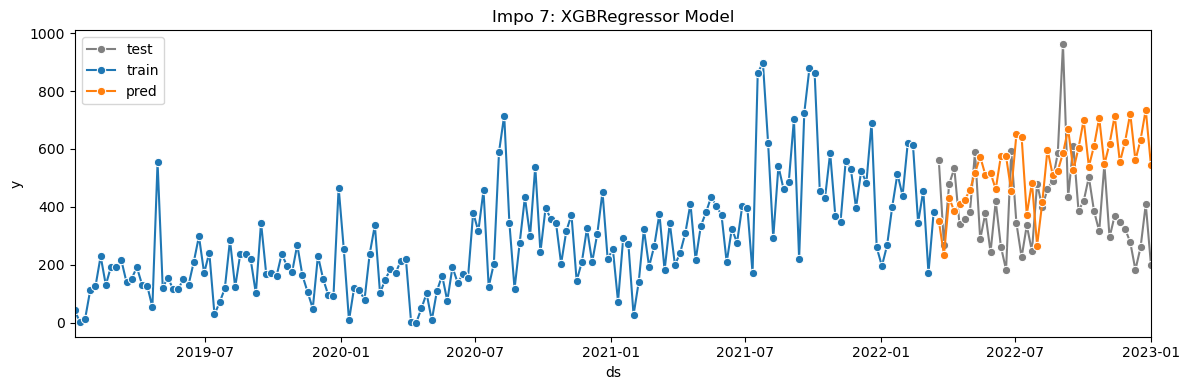

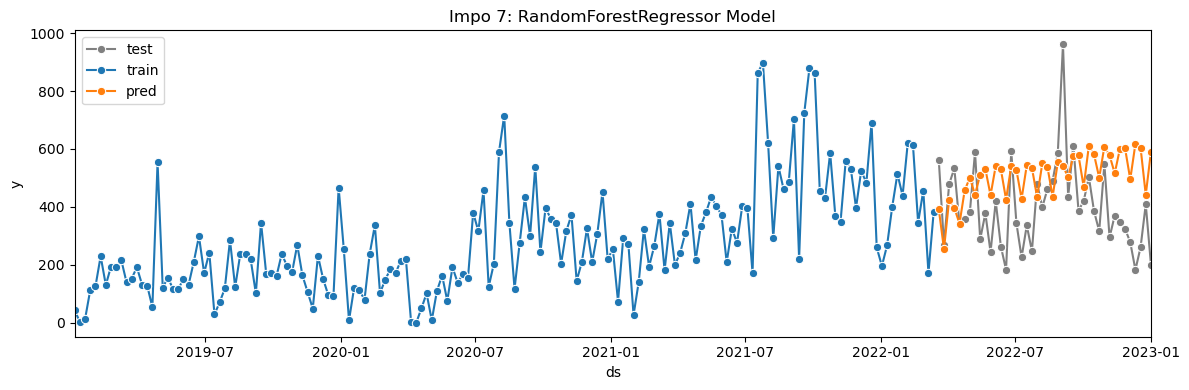

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

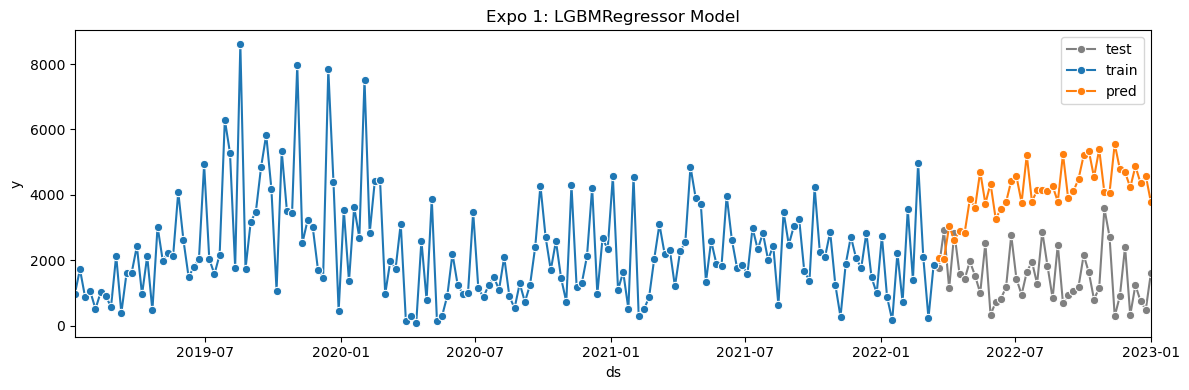

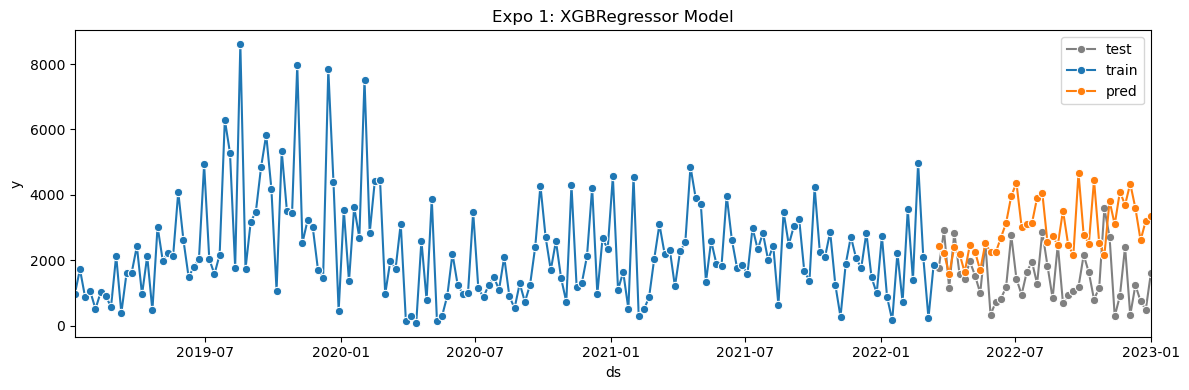

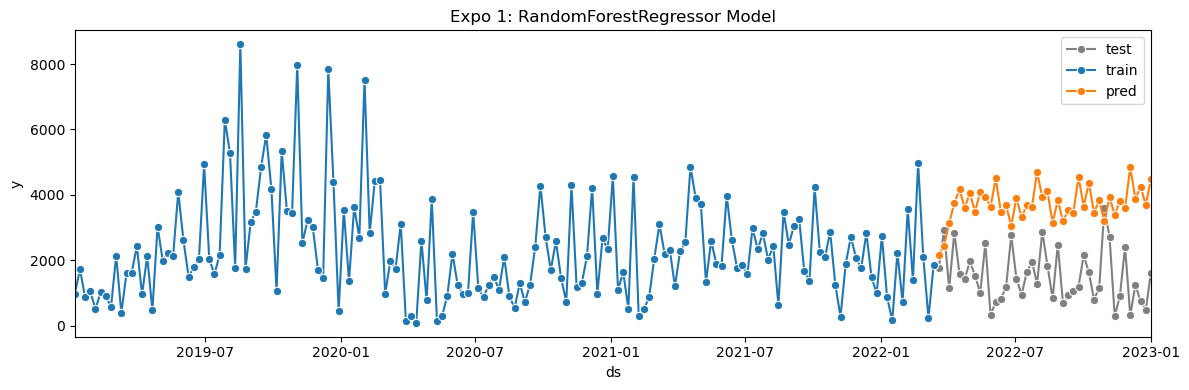

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

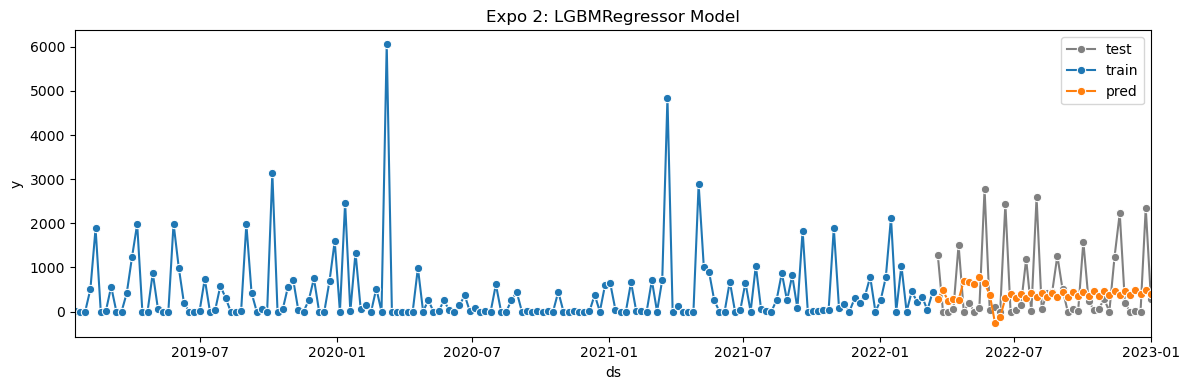

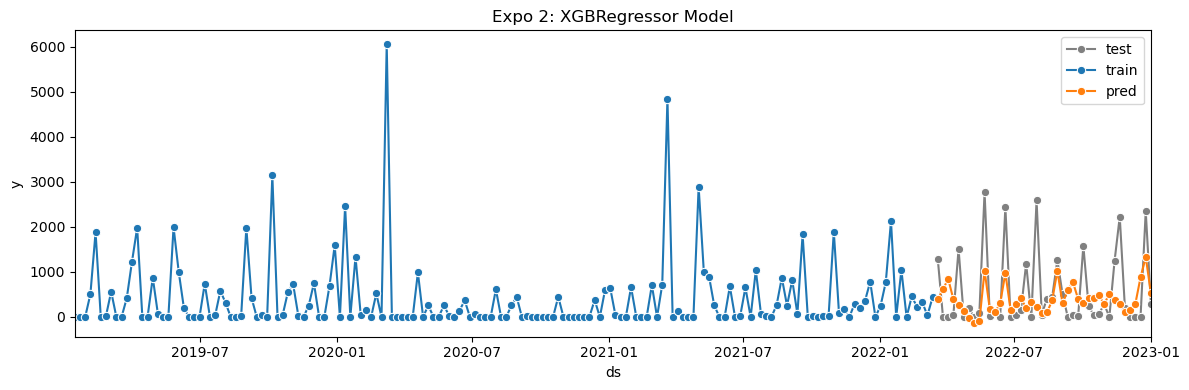

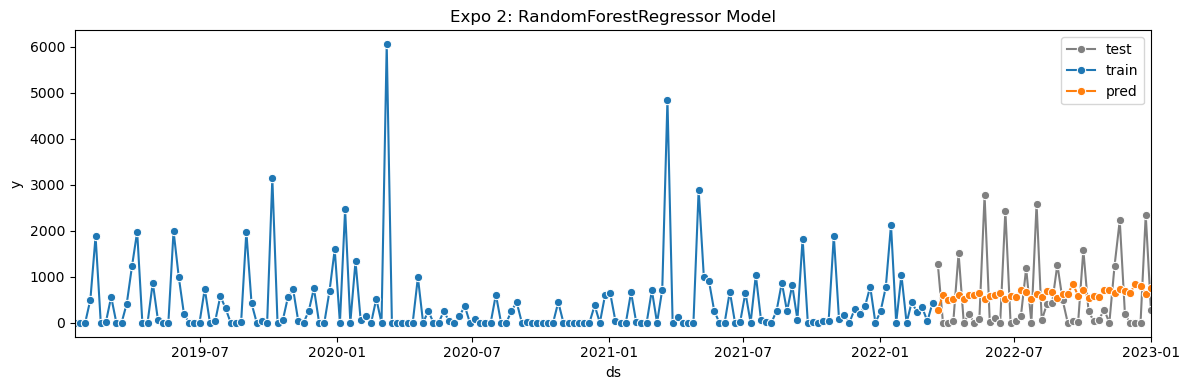

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

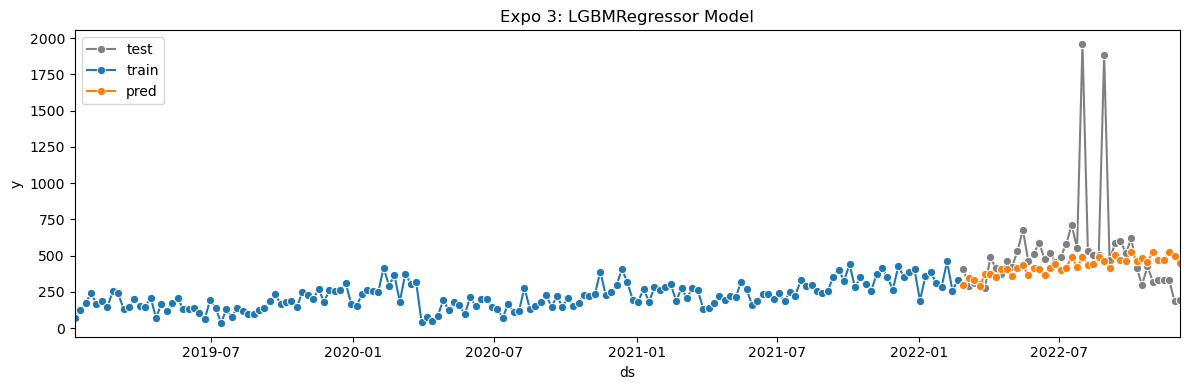

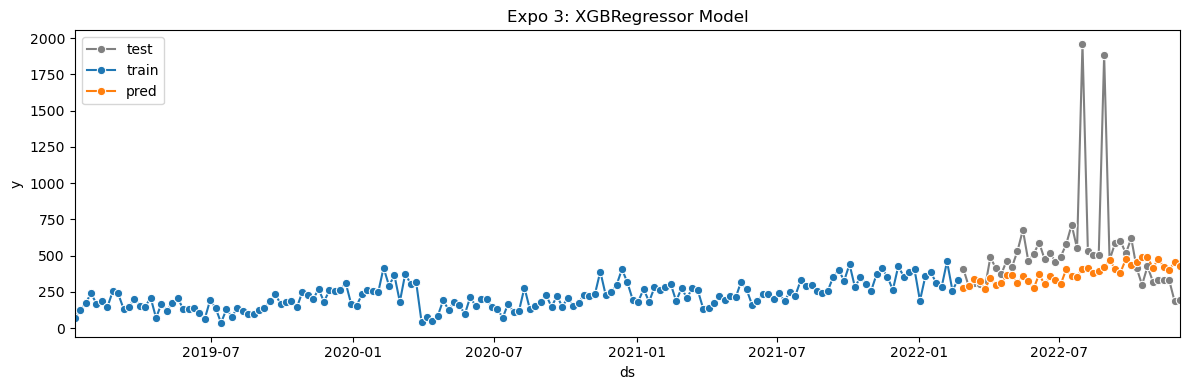

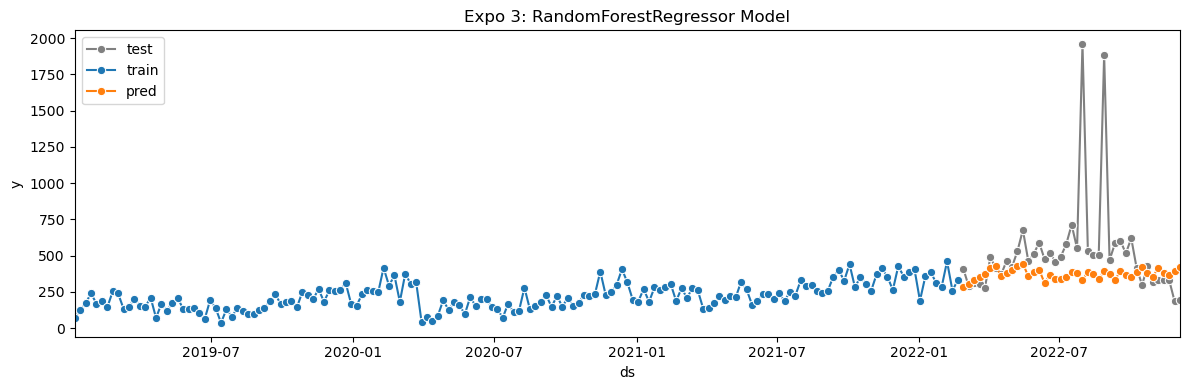

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Bravo15\AppData\Local\Temp\ipykernel_21644\3003954497.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

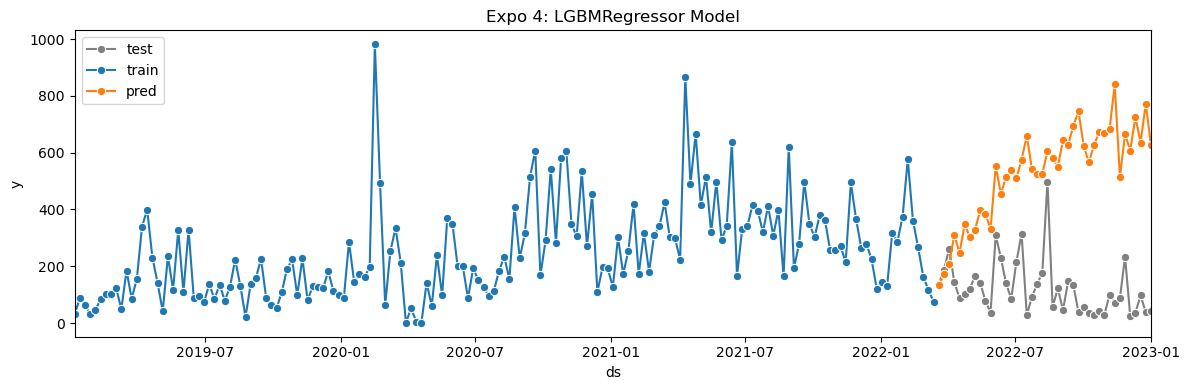

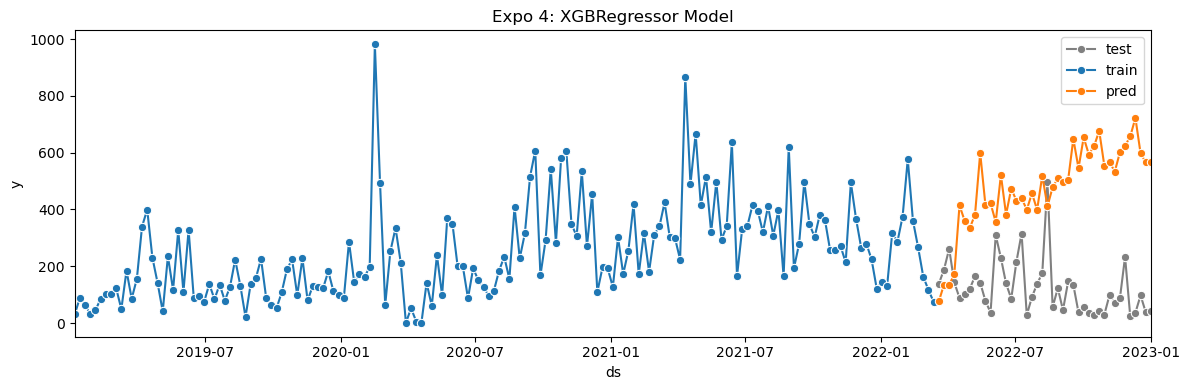

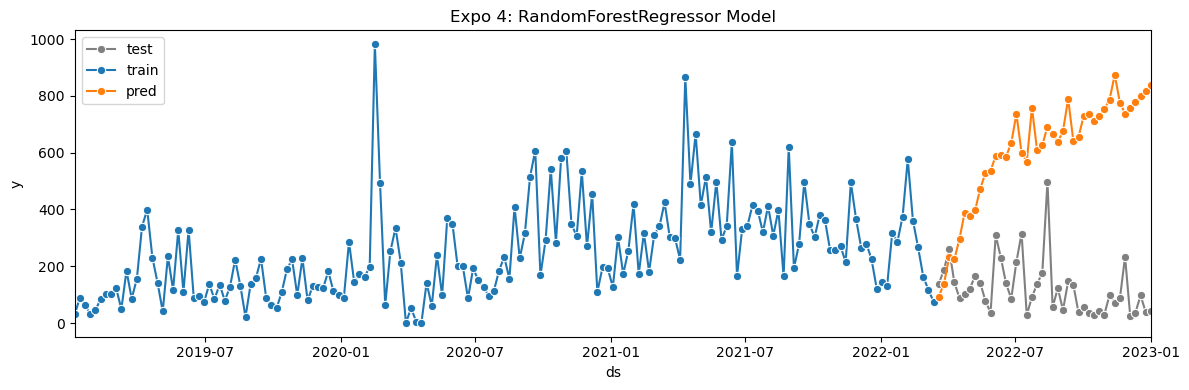

In [25]:
comparison_tbl= ml_model(models, df_impo_1, 'Impo 1', comparison_tbl)
comparison_tbl= ml_model(models, df_impo_2, 'Impo 2', comparison_tbl)
comparison_tbl= ml_model(models, df_impo_3, 'Impo 3', comparison_tbl)
comparison_tbl= ml_model(models, df_impo_4, 'Impo 4', comparison_tbl)
comparison_tbl= ml_model(models, df_impo_5, 'Impo 5', comparison_tbl)
#comparison_tbl= ml_model(models, df_impo_6, 'Impo 6', comparison_tbl)
comparison_tbl= ml_model(models, df_impo_7, 'Impo 7', comparison_tbl)
comparison_tbl= ml_model(models, df_expo_1, 'Expo 1', comparison_tbl)
comparison_tbl= ml_model(models, df_expo_2, 'Expo 2', comparison_tbl)
comparison_tbl= ml_model(models, df_expo_3, 'Expo 3', comparison_tbl)
comparison_tbl= ml_model(models, df_expo_4, 'Expo 4', comparison_tbl)

In [26]:
comparison_tbl.sort_values(by='RMSE').head(10)

Serie                     Modelo         MAE        RMSE     sMAPE  \
2   Impo 3   SARIMAX ([1, 2], 0, [5])   42.912352   77.237038  1.431710   
18  Impo 3               XGBRegressor   75.622170  105.299900  1.935443   
19  Impo 3      RandomForestRegressor   84.020881  111.310951  1.943626   
10  Expo 4   SARIMAX ([1, 2], 1, [2])   96.732396  137.010334  0.726832   
17  Impo 3              LGBMRegressor  123.348228  146.961868  1.950106   
6   Impo 7  SARIMAX ([1, 2], 0, [10])  141.687432  183.721246  0.342107   
28  Impo 7      RandomForestRegressor  164.827971  197.993568  0.379400   
3   Impo 4      SARIMAX ([2], 0, [1])  185.779630  213.952750  0.812257   
27  Impo 7               XGBRegressor  205.326833  244.927493  0.447455   
26  Impo 7              LGBMRegressor  233.122305  274.071122  0.482486   

   Processing Time  
2           1.9706  
18          1.2521  
19          1.2521  
10          0.9695  
17          1.2521  
6           6.1446  
28          1.2346  
3           0.5379  
27          1.2346  
26          1.2346

Es evidente que estos primeros resultados no son los esperados, y decepciona ver como modelos estadisticos clasicos con un buen tuneo de hiperparametros logran mejor performance que modelos de ML. Sin embargo, no sorprenden los resultados ya que las series poseen comportamientos particulares y erráticos como se observo en las primeras secciones del análisis, esto provoca que el modelado de las series sea más complejo por lo que en las siguientes secciones intentaré mejorar las perfomance de los modelos a través de distintas herramientas.

ML clasico 
- Hacer param gridsearch 
- nixtla correr varios modelos juntos con el unique_id a ver si mejoran 
- LugonTS: amazon, modelo clasico se llama DeepAR (red recurrente, mucho mas maduro), buen baseline para AR en los modelos de deep learing
- modelos de redes neuronales probar 

Probar correr todos los modelos juntos para todas las series

Nixtla: mlforecast nos permite entrenar todas las series juntas y luego predecir individualmente para cada una de ellas. Esto permite entrenar un modelo que se retroalimente de las series y logre captar tendencias y patrones comunes entre ellas. Compararemos los resultados con los obtenidos en la fase previa

#### 2.2 ML Nixtla - Entrenamiento conjunto
En esta sección, correré los mismos modelos pero al utilizar la libreria Nixtla me permite entrenar los modelos para todas las series en conjunto, asi logro que el modelo capture patrones de todos los motivos pudiendo aplicar insights cruzados entre si, ya que recordemos que las series representan los motivos y rutas pero tienen factores en comun como: la situacion economica de Argentina en ese momento del tiempo, el tipo de cambio, la disposicion a pagar de los clientes, las condiciones economicas internacionales, etc.  Por ello, factores que afecten a una serie probablemente afecten a las demas, de esta forma se pueden tener insights cruzados entre ellas permitiendo una mejor performance del modelo. 

Desafortunadamente, este tipo de librerias no permiten realizar un param grid search ya que se deberia hacer por cada serie uno, por ello dejare el tuneo de hiperparametros para la siguiente seccion donde utilizare otra libreria. 


Creamos el dataset unificado donde con la columan unique_id diferenciare las series entre si

In [27]:
def unificar_df(lista_dataframe):
    
    lista_df_clean= []
    n=0
    
    for df in lista_dataframe: 
        df[['unique_id']]= lista_df[n][3:]
        dff = df[['unique_id','ds', 'y']]
        lista_df_clean.append(dff)
        n+=1
    
    df_unificado= pd.concat(lista_df_clean)
    
    return df_unificado

In [28]:
df_unificado= unificar_df(lista_dataframe)

In [29]:
df_unificado.head()

unique_id         ds       y
0    impo_1 2019-01-06  1950.0
1    impo_1 2019-01-13  2402.0
2    impo_1 2019-01-20  2782.0
3    impo_1 2019-01-27  3263.0
4    impo_1 2019-02-03  3843.0

In [30]:
def modelado_nixtla_conjunto(models, df_unificado, comparison_tbl): 
    
    """Permite modelar varios modelos de ML a la vez, entrenando todas las series juntas diferenciandola por el unique_id"""
    
    tic = time.clock()

    fcst = MLForecast(
        models=models,
        freq='W',
        lags=[7, 14],
        lag_transforms={
            1: [expanding_mean]},
        target_transforms=[Differences([1])],
    )
    
    #separamos en train y test 
    #para lograr comparar todos los modelos entre si, elegi un periodo de 20 semanas para testear todos, evaluando cumple
    #en la mayoria de los casos con una proporcion razonable entre train y test
    unique_ids = df_unificado['unique_id'].unique() 
    
    #escalo los datos para que los modelos puedan captar informacion entre si, ya que si no escalo no logran realizar el entrenamiento cruzado que se busca
    min_max_scaler = preprocessing.MinMaxScaler()
    df_unificado[['y']]=min_max_scaler.fit_transform(df_unificado[['y']])

    # Crear listas para almacenar los DataFrames de train y test
    train_dfs = []
    test_dfs = []

    for unique_id in unique_ids:
    
        serie_df = df_unificado[df_unificado['unique_id'] == unique_id]
        test_df = serie_df.iloc[-20:]  # Últimas 20 semanas para el conjunto de prueba
        train_df = serie_df.iloc[:-20]  # Resto para el conjunto de entrenamiento
    
        train_dfs.append(train_df)
        test_dfs.append(test_df)

    # Concatenar los DataFrames de train y test
    df_train = pd.concat(train_dfs)
    df_test = pd.concat(test_dfs)

    #entrenamos el modelo
    fcst.fit(df_train)
    
    #obtenemos un df de predictions con las predicciones para todas las series juntas
    
    predictions = fcst.predict(20) 
    print(predictions.columns)
    toc =  time.clock() #frenamos el cronometro y a continuacion creamos la variable que guarda el tiempo transcurrido desde que empezo a correr el modelo hasta q termino
    exetime = '{0:.4f}'.format(toc-tic)
    
    model_names=['LinearRegression', 'XGBRegressor','RandomForestRegressor']
    
    lista_id= []
    lista_model= []
    lista_mae=[]
    lista_rmse=[]
    lista_smape=[]
    lista_exetime=[]

    for unique_id in unique_ids: 
        for model in model_names: 
            
            train_date= df_train[df_train['unique_id']== unique_id]['ds']
            test_date= df_test[df_test['unique_id']==unique_id]['ds']
            predicted_ds= predictions[predictions['unique_id']==unique_id]['ds']
            
            train_values= df_train[df_train['unique_id']== unique_id]['y']
            
            
            actual_values= df_test[df_test['unique_id']==unique_id]['y']
            predicted_values= predictions[predictions['unique_id']== unique_id][model]
         
            mae = mean_absolute_error(actual_values, predicted_values)
            rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
            smape = calculate_smape(actual_values, predicted_values)
            
            lista_id.append(unique_id)
            lista_model.append(f'Nixtla Conjunto: {model}')
            lista_mae.append(mae)
            lista_rmse.append(rmse)
            lista_smape.append(smape)
            lista_exetime.append(exetime)
            
            #graficamos los resultados
            f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
            sns.lineplot(x=test_date, y=actual_values, marker='o', label='test', color='grey')
            sns.lineplot(x=train_date, y=train_values, marker='o', label='train')
            sns.lineplot(x=predicted_ds, y=predicted_values, marker='o', label='pred', color ='orange')
            ax.set_title(f'{unique_id}: Nixtla Conjunto {model}')
            plt.tight_layout()
            plt.show()
    
    
    raw_data = {'Serie': lista_id,
                'Modelo': lista_model,
                'MAE':  lista_mae,
                'RMSE': lista_rmse,
                'sMAPE': lista_smape, 
                'Processing Time': lista_exetime}
    
    df_tbl = pd.DataFrame(raw_data)

    comparison_tbl = pd.concat([comparison_tbl, df_tbl], ignore_index=True)
    
    return comparison_tbl
    
    

Index(['unique_id', 'ds', 'LinearRegression', 'XGBRegressor',
       'RandomForestRegressor'],
      dtype='object')


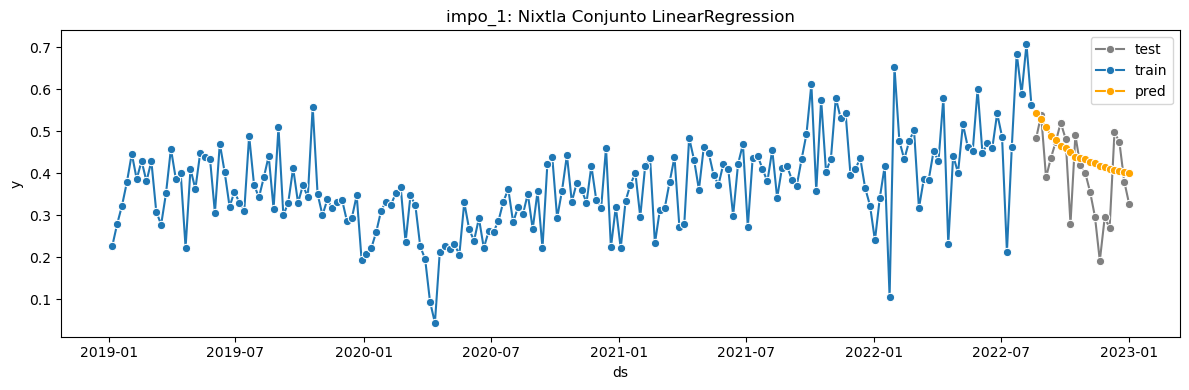

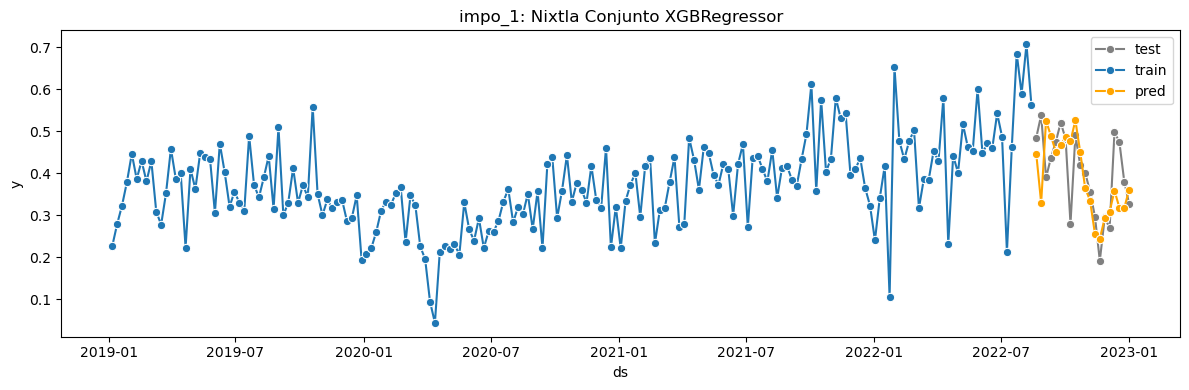

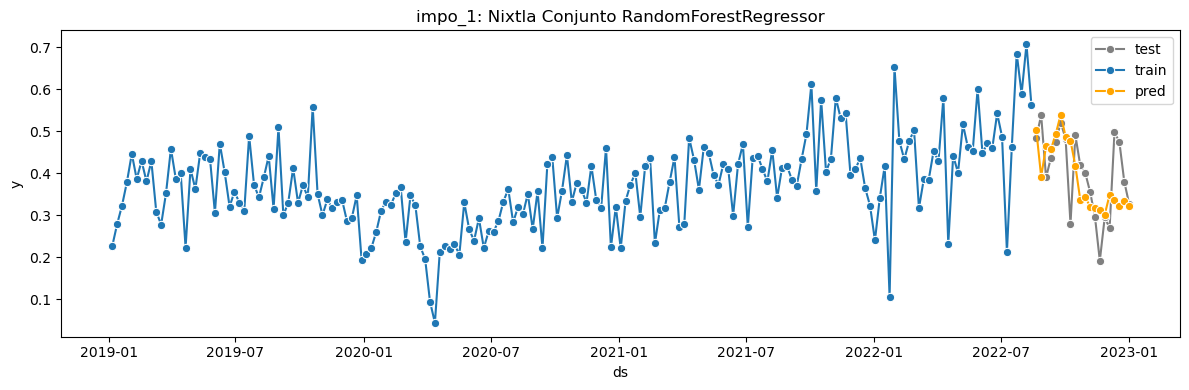

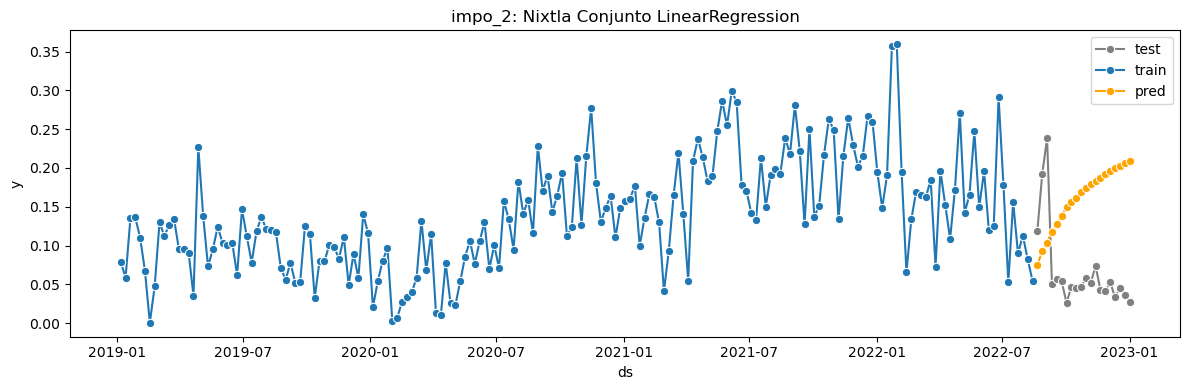

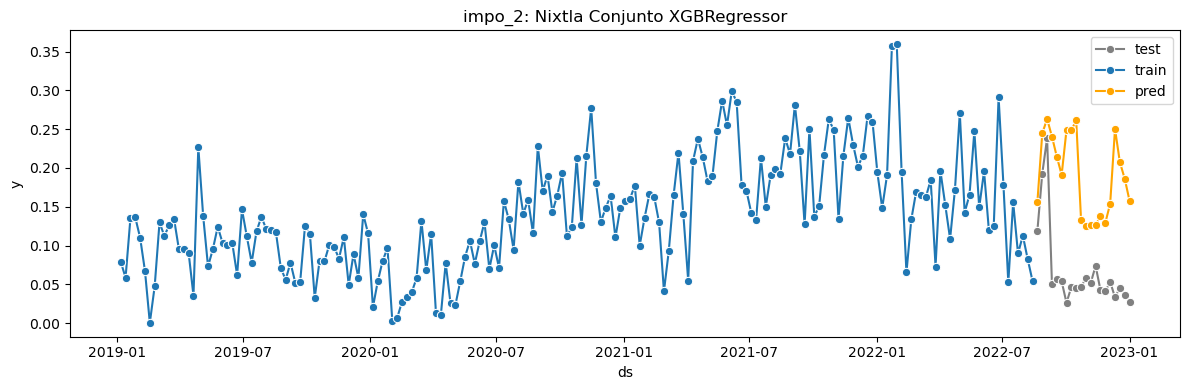

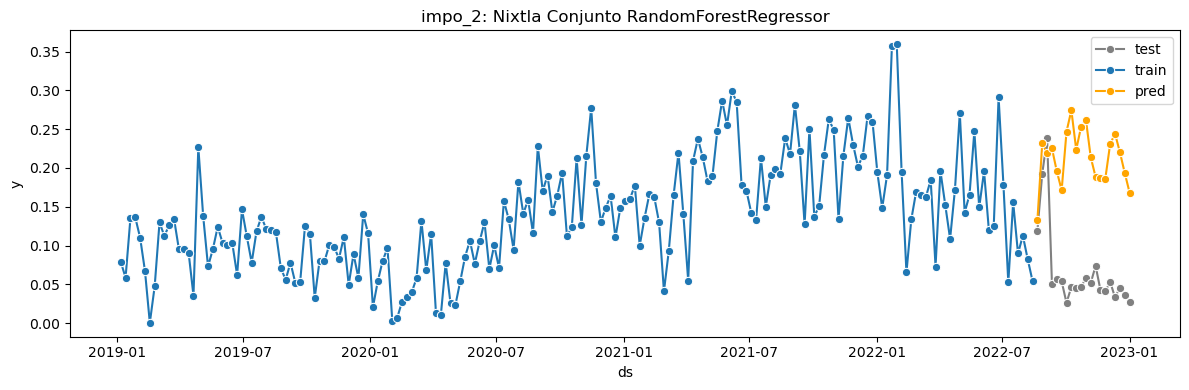

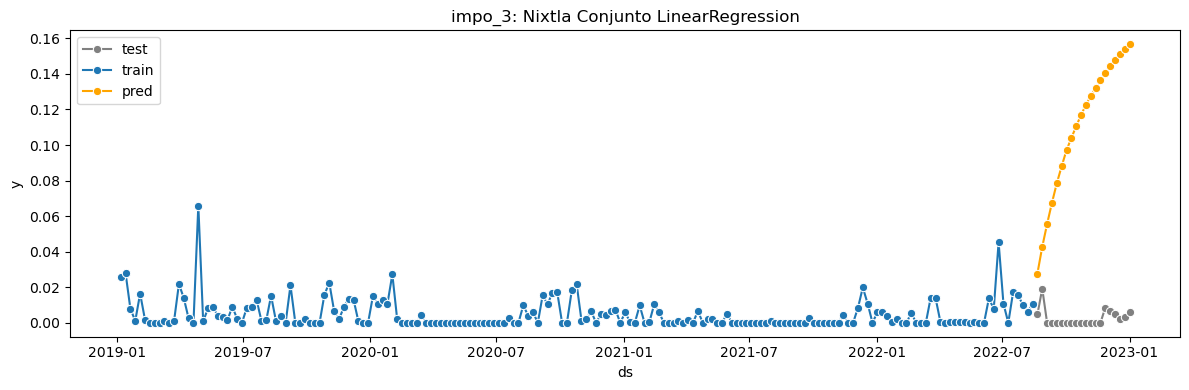

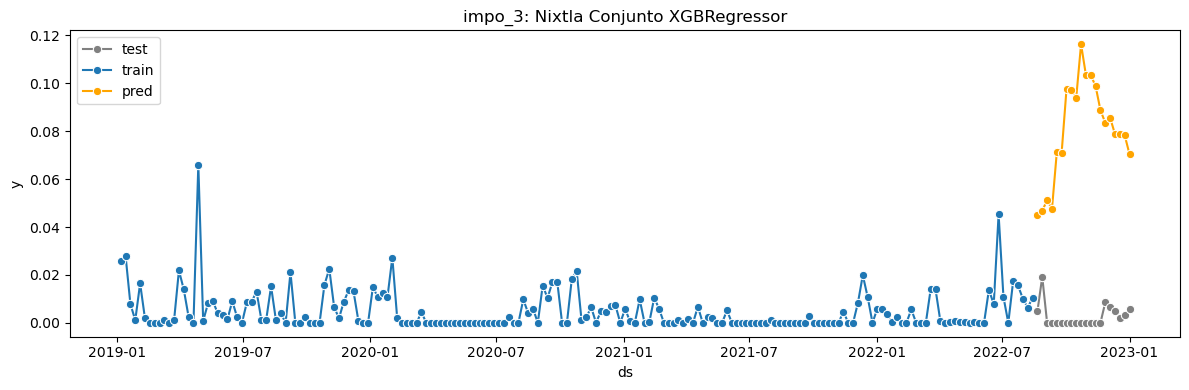

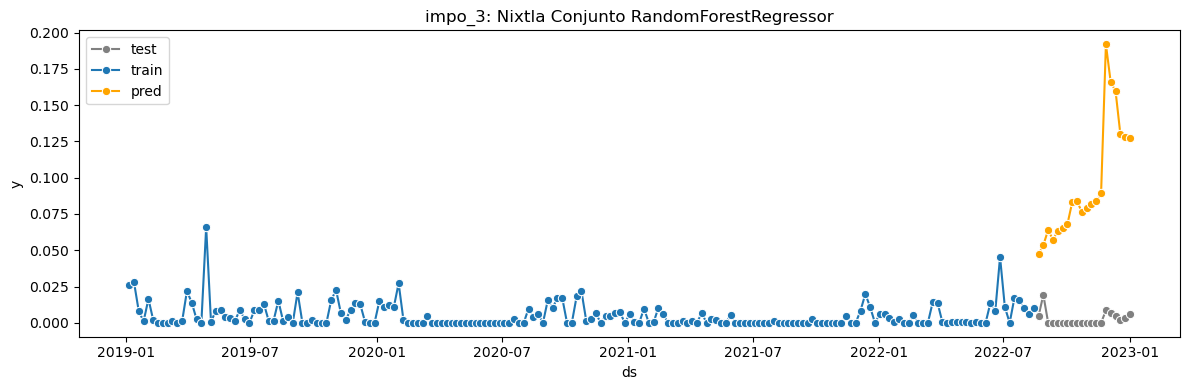

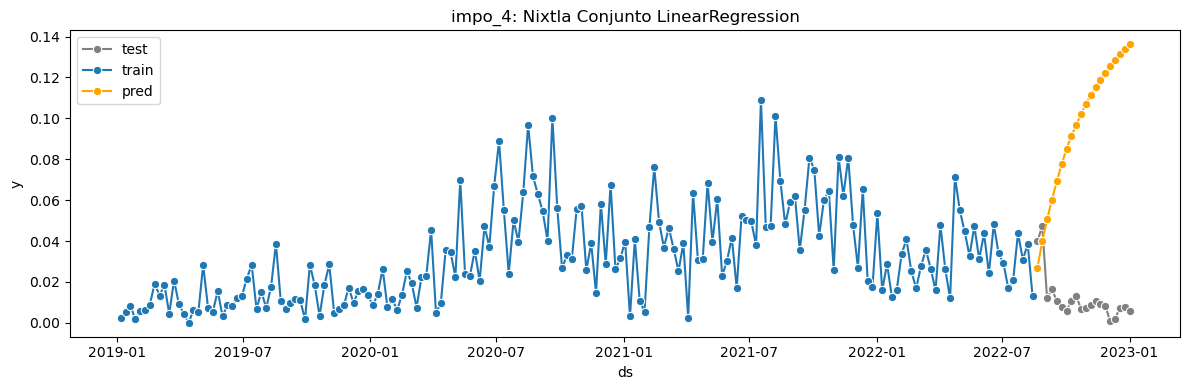

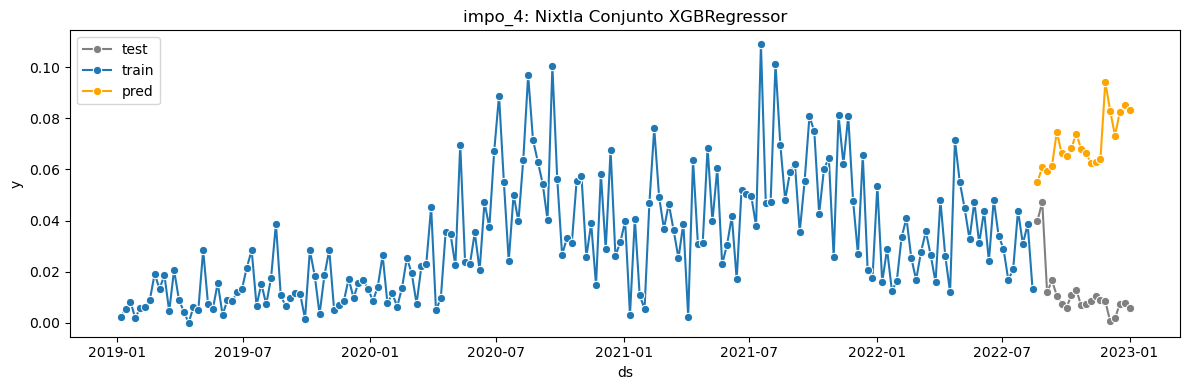

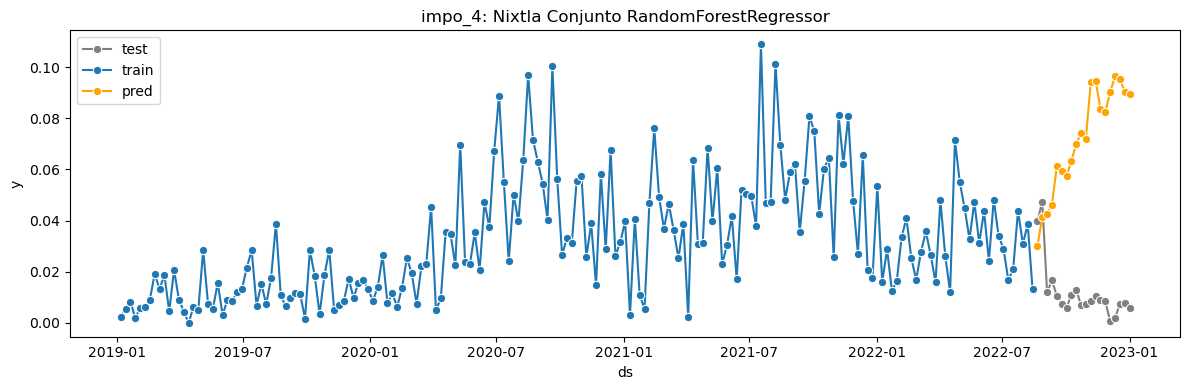

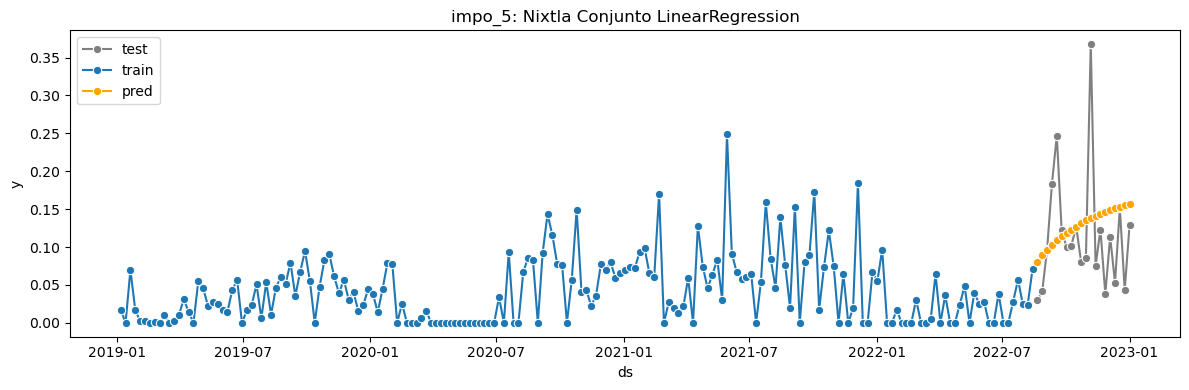

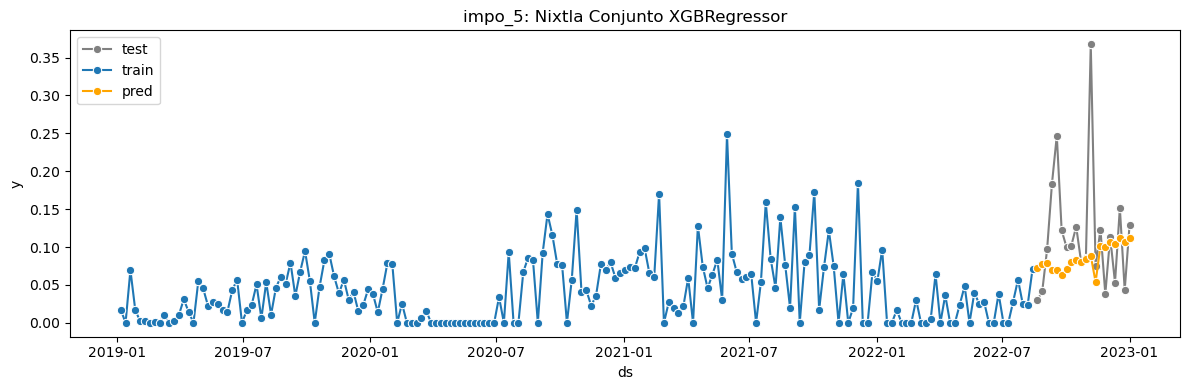

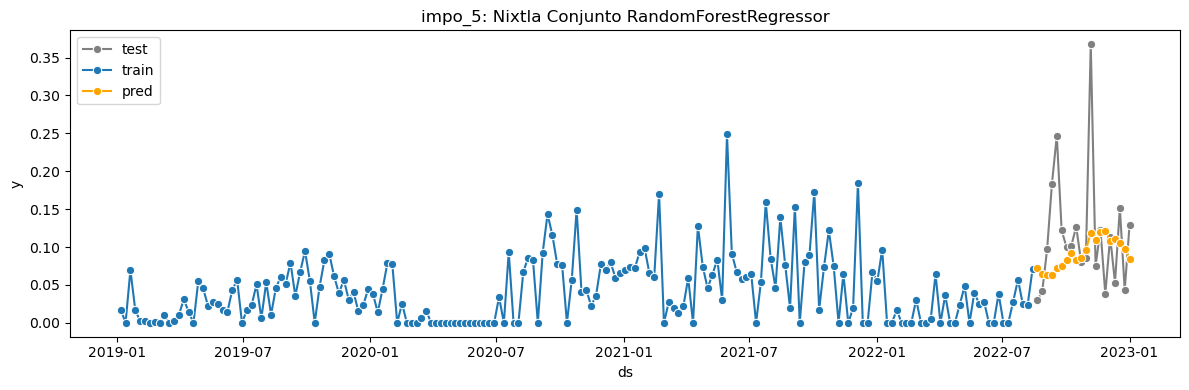

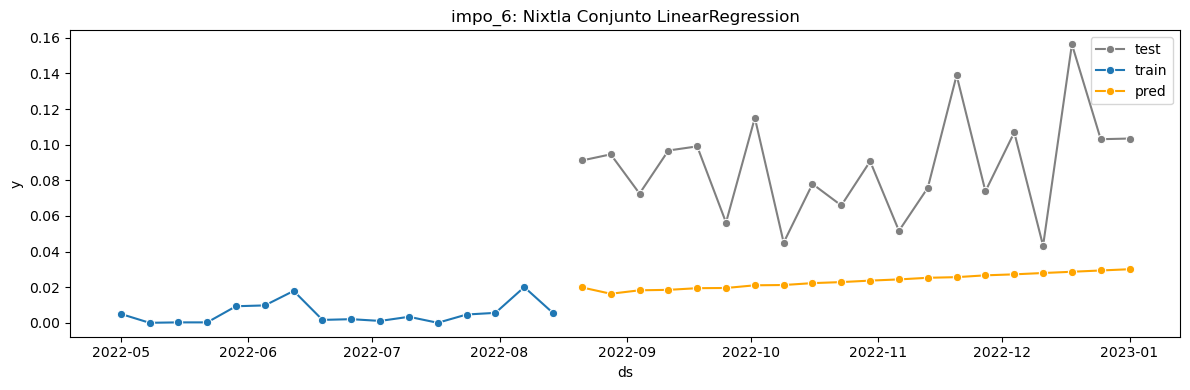

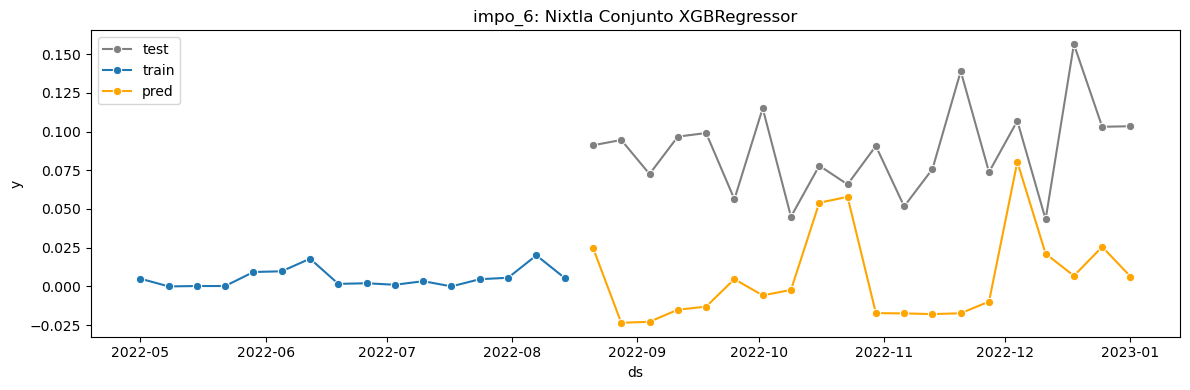

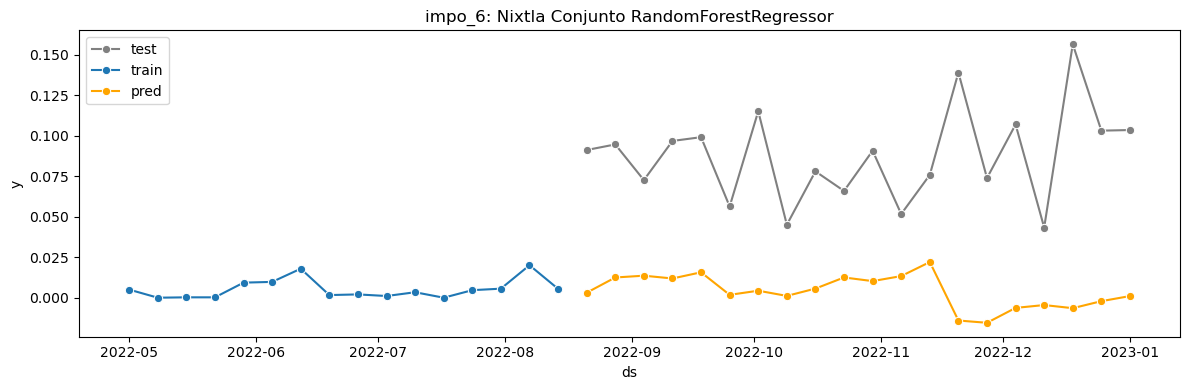

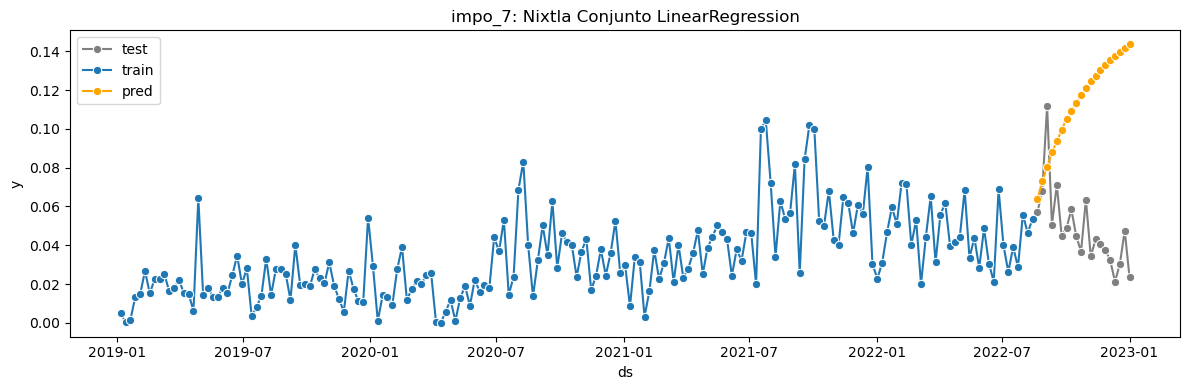

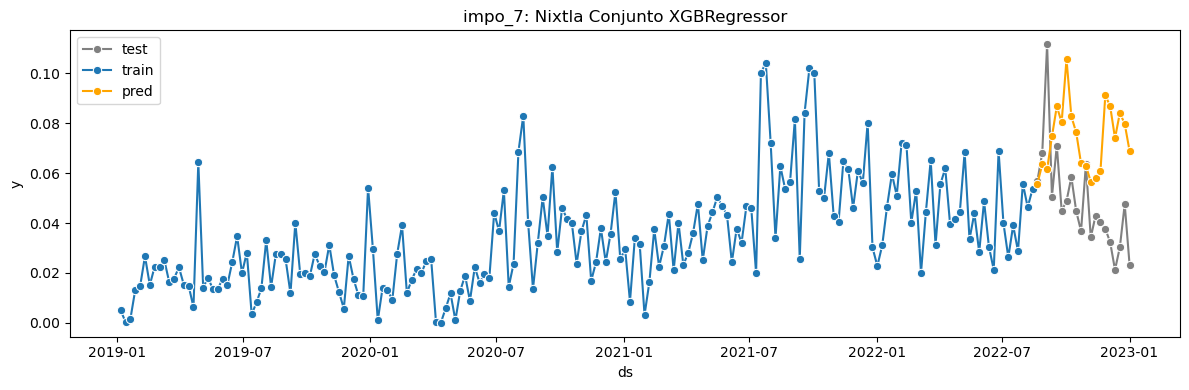

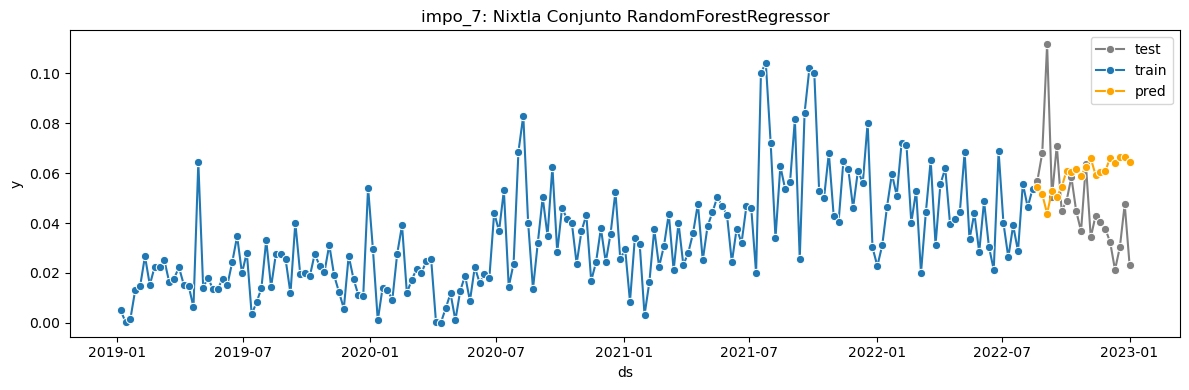

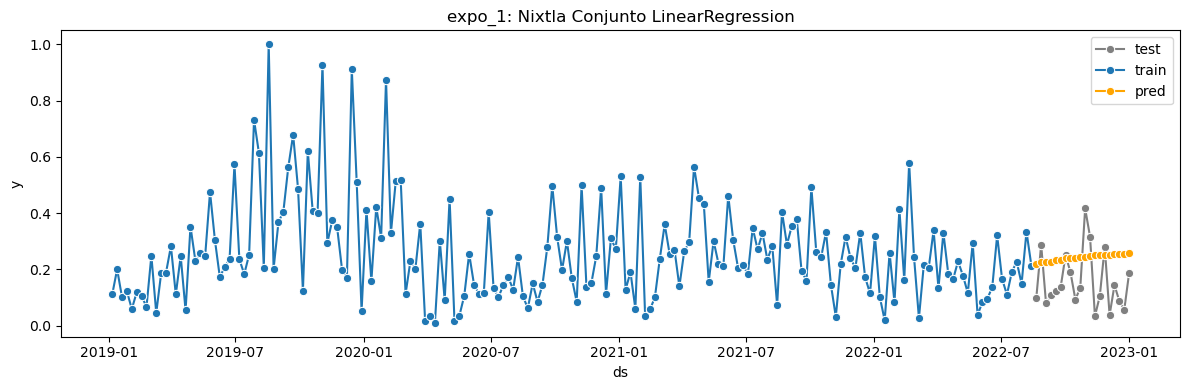

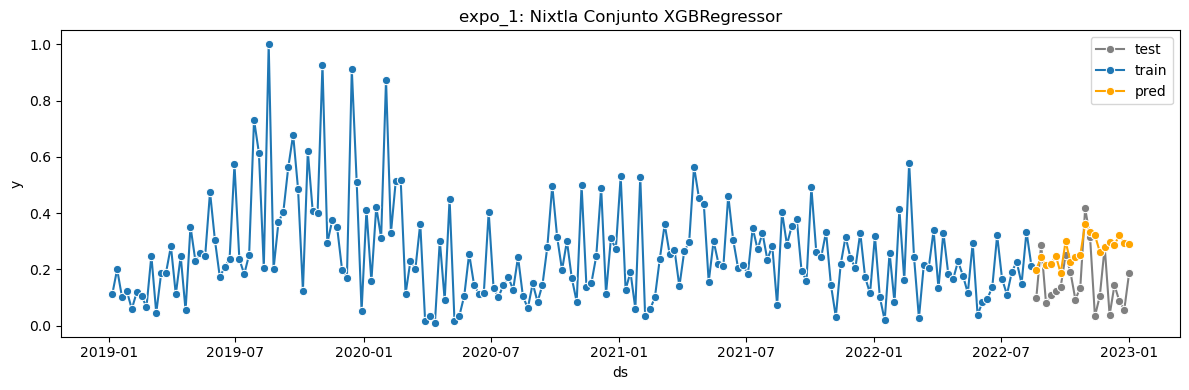

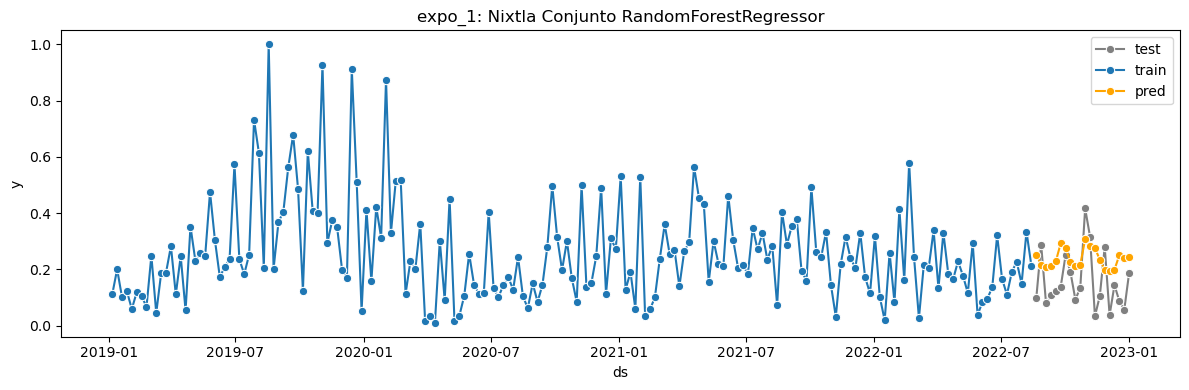

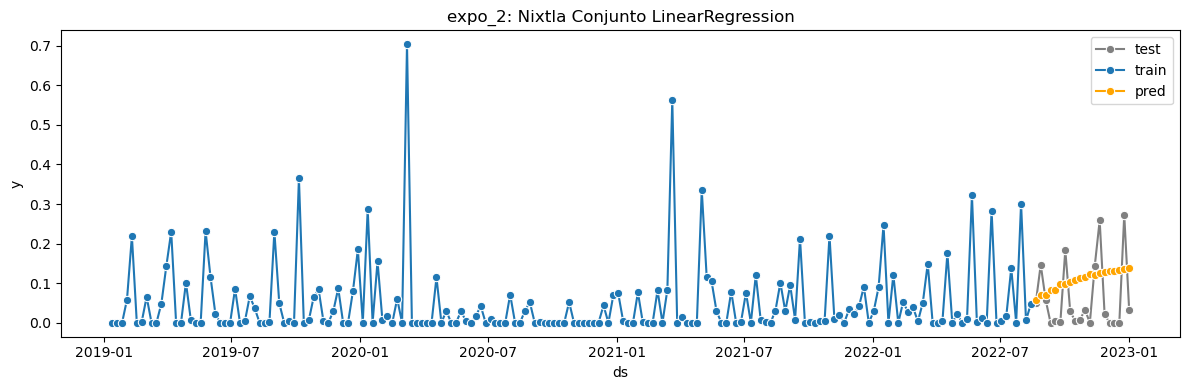

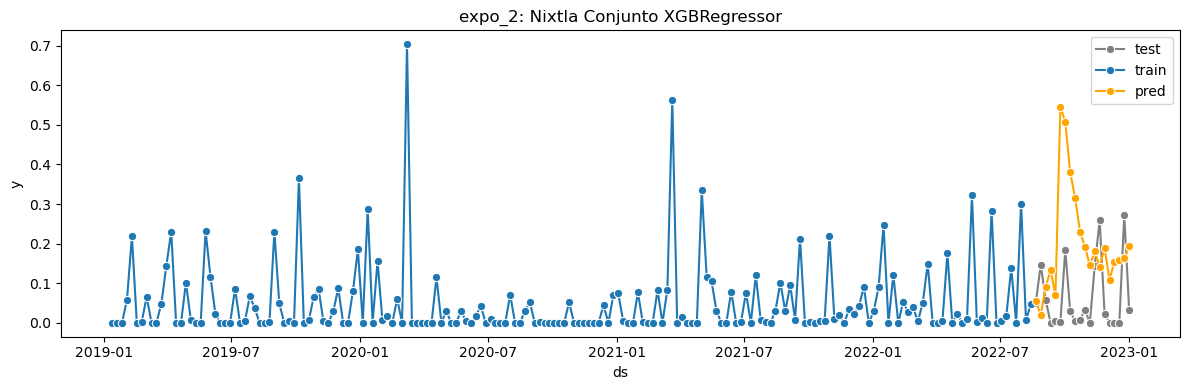

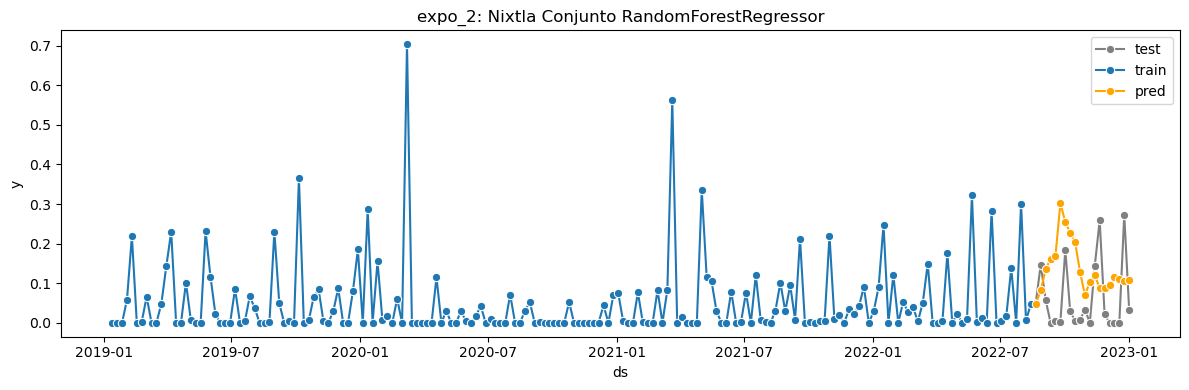

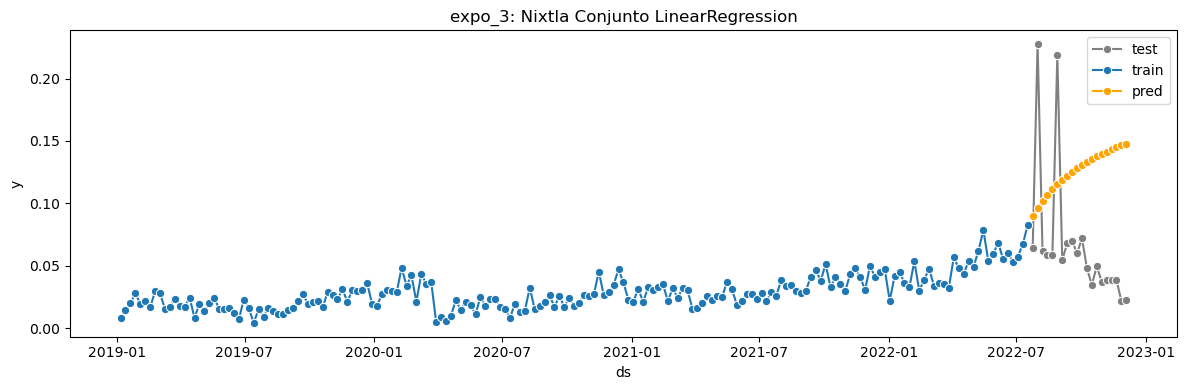

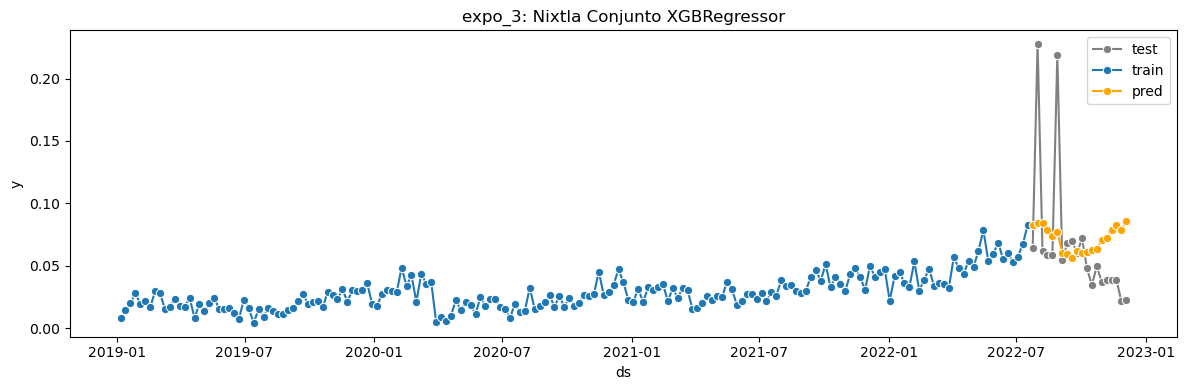

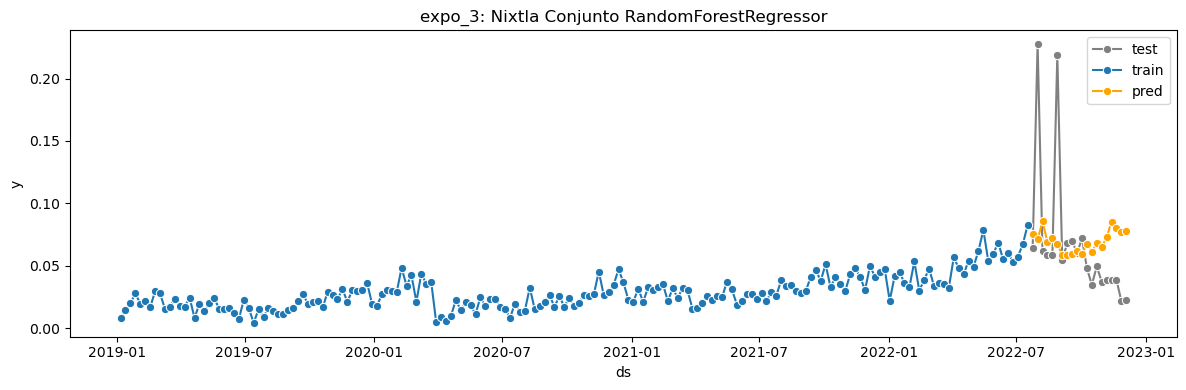

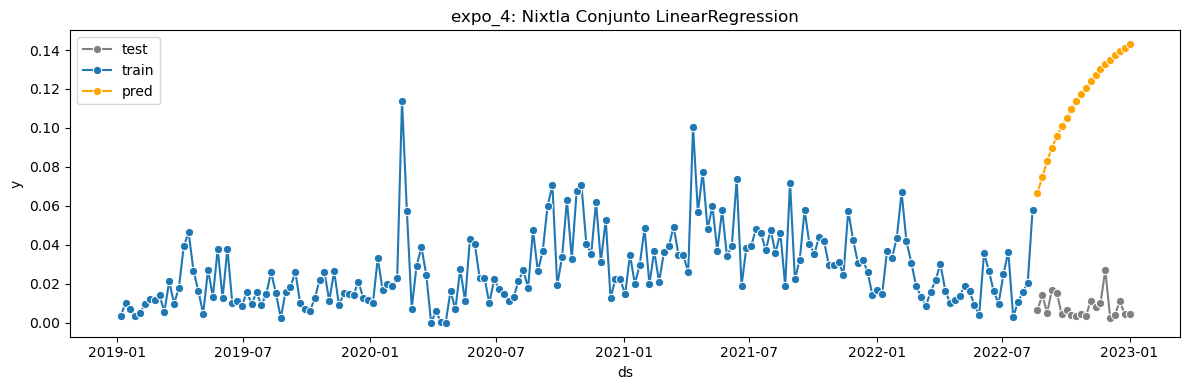

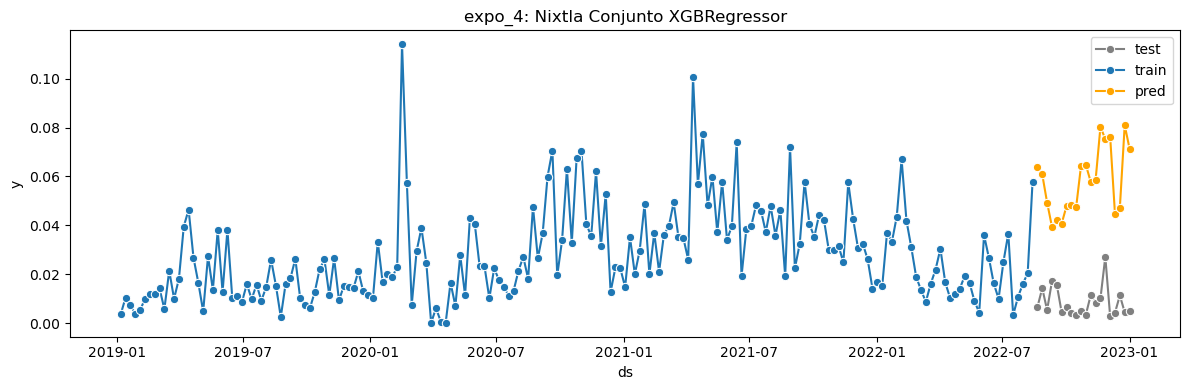

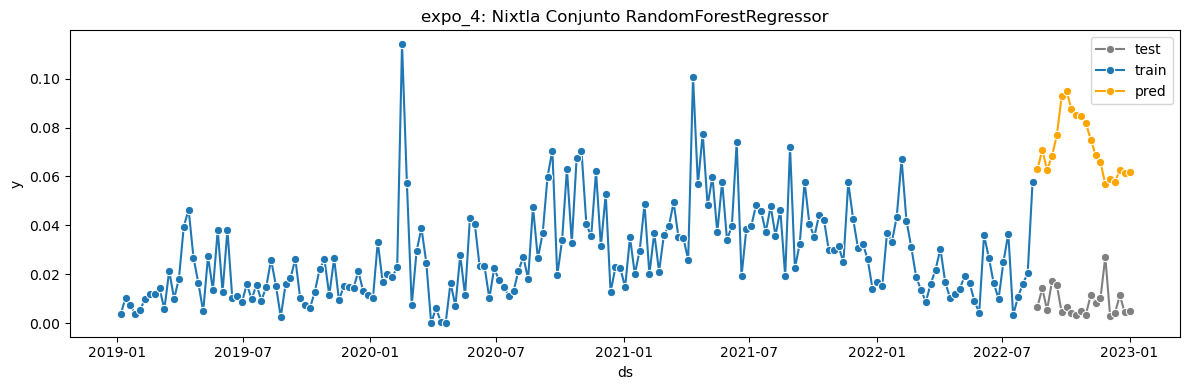

In [31]:
models = [
    LinearRegression(),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]

comparison_tbl= modelado_nixtla_conjunto(models, df_unificado, comparison_tbl)

In [32]:
comparison_tbl.sort_values(by='RMSE').head(10)

Serie                                  Modelo       MAE      RMSE  \
61  impo_7  Nixtla Conjunto: RandomForestRegressor  0.021861  0.027254   
60  impo_7           Nixtla Conjunto: XGBRegressor  0.031104  0.036040   
72  expo_4           Nixtla Conjunto: XGBRegressor  0.049561  0.051642   
69  expo_3           Nixtla Conjunto: XGBRegressor  0.036486  0.053272   
70  expo_3  Nixtla Conjunto: RandomForestRegressor  0.036521  0.055779   
51  impo_4           Nixtla Conjunto: XGBRegressor  0.058625  0.061455   
73  expo_4  Nixtla Conjunto: RandomForestRegressor  0.063373  0.065063   
52  impo_4  Nixtla Conjunto: RandomForestRegressor  0.061400  0.066520   
56  impo_6       Nixtla Conjunto: LinearRegression  0.064505  0.070317   
59  impo_7       Nixtla Conjunto: LinearRegression  0.068718  0.076856   

       sMAPE Processing Time  
61  0.416879          1.8232  
60  0.522464          1.8232  
72  1.494013          1.8232  
69  0.481011          1.8232  
70  0.479338          1.8232  
51  1.448540          1.8232  
73  1.581064          1.8232  
52  1.435338          1.8232  
56  1.108079          1.8232  
59  0.832893          1.8232

El hecho de entrenar las series en conjunto mejoro los resultados obtenidos previamente para la mayoria de las series se observa que los modelos de ML aunque los resultados son mejores que para los modelos clasicos, los resultados no son optimos ya que en la mayoria de las series el modelo no logra predecir con certeza los kilos para las proximas 20 semanas, tal como se observa en las graficas obtenidas con los resultados. Por ello, en la siguiente seccion se buscaran mejorar los resultados con modelos de redes neuronales. 

#### 3. Redes Neuronales

En esta seccion probare distintos modelos de Redes neuronales



##### 3.1 DeepAR - GluonTS [mxnet]
https://ts.gluon.ai/stable/

https://forecastegy.com/posts/multiple-time-series-forecasting-with-deepar-in-python/  -> clave los parametros

muy completo https://medium.com/@corymaklin/deepar-forecasting-algorithm-6555efa63444

tambien esta bueno es solo para una serie pero buenas metrcias https://kekayan.medium.com/forecasting-with-deepar-for-busy-people-ed67f9d9a00d

DeepAR is a deep learning algorithm based on recurrent neural networks designed specifically for time series forecasting.

It works by learning a model based on all the time series data, instead of creating a separate model for each one.

In my experience, this often works better than creating a separate model for each time series.

The model is based on an autoregressive architecture, which means that it uses information from previous time steps to predict future values.

It has two parts: an encoder network, which remembers what it has seen, and a decoder network, which predicts what will happen next.

It learns a conditional distribution over the future values and uses a recursive approach to generate predictions for multiple time steps.

So instead of simply predicting a point estimate, it samples values from the learned distribution and uses that as the prediction.

##### Preparacion del dataset

Podria ser interesante agregarle una variable que sea que tipo de servicio es, por lo que agregaremos una columna que indica si el motivo corresponde a impo o a expo, donde 1 indica que pertence a impo y 0 que pertenece a expo

https://forecastegy.com/posts/multiple-time-series-forecasting-with-deepar-in-python/

In [33]:
def unificar_df_ar(lista_df):
    
    lista=[]
    for df in lista_df: 
        
        df= df[['ds', 'family', 'y']]
        lista.append(df)
    
    df_final = pd.concat(lista, ignore_index=True)
    

    df_final = df_final[['ds', 'family', 'y']]
    df_final.style.format({"ds": lambda t: t.strftime("%d-%m-%Y")})
    
    return df_final    

##### 3.2 FB Prophet 

Facebook developed an open sourcing Prophet, a forecasting tool available in both Python and R. It provides intuitive parameters which are easy to tune. Even someone who lacks deep expertise in time-series forecasting models can use this to generate meaningful predictions for a variety of problems in business scenarios.

The Prophet uses a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:

y(t)= g(t) + s(t) + h(t) + εt

g(t): piecewise linear or logistic growth curve for modeling non-periodic changes in time series
s(t): periodic changes (e.g. weekly/yearly seasonality)
h(t): effects of holidays (user provided) with irregular schedules
εt: error term accounts for any unusual changes not accommodated by the model
Using time as a regressor, Prophet is trying to fit several linear and non linear functions of time as components. Modeling seasonality as an additive component is the same approach taken by exponential smoothing in Holt-Winters technique . Prophet is framing the forecasting problem as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a time series.

https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274
